## Get best and median fold

In [1]:
import glob
import pandas as pd

properties = ["MOD_UNG", "ANY_TEC", "TLiq", "NUD300", "ND300", "TG"]
measure = "R2"
model = "rf"

medians = []
bests = []
for prop in properties:
    all_files = glob.glob(f"data2/logs/performance_best_models_{prop}*.csv")

    perf_perfold_list = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=0)
        fold = filename.split('fold')[1].split('.csv')[0]
        perf = df[model][measure]
        perf_perfold_list.append([fold, perf])

    perf_perfold_df = pd.DataFrame(perf_perfold_list, columns=["fold", "perf"])

    median = perf_perfold_df['perf'].median()
    aux = (perf_perfold_df['perf'] - median).abs()
    aux_median_model = perf_perfold_df[aux == aux.min()].sort_values(by='perf', ascending=False)
    aux_best_model = perf_perfold_df.sort_values(by='perf', ascending=False)

    median_fold = aux_median_model["fold"].iloc[0]
    best_fold = aux_best_model["fold"].iloc[0]
    
    medians.append(median_fold)
    bests.append(best_fold)
    print(f"Median fold for {prop} is {median_fold}")
    print(f"Best fold for {prop} is {best_fold}")
    print()
    
    
df_folds = pd.DataFrame([["median"]+medians, ["best"]+bests], columns=["TP"]+properties).set_index(["TP"])
df_folds

Median fold for MOD_UNG is 08
Best fold for MOD_UNG is 06

Median fold for ANY_TEC is 02
Best fold for ANY_TEC is 09

Median fold for TLiq is 07
Best fold for TLiq is 09

Median fold for NUD300 is 08
Best fold for NUD300 is 09

Median fold for ND300 is 01
Best fold for ND300 is 03

Median fold for TG is 04
Best fold for TG is 05



MOD_UNG ANY_TEC TLiq NUD300 ND300  TG
TP                                          
median      08      02   07     08    01  04
best        06      09   09     09    03  05

## Generating SHAP plot

In [2]:
import os
import gzip
import pickle
import shap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


PERCENTILES = [20, 80]

# funcao cedida pelo Daniel para fazer percentil
def feature_label(all_x, all_y, pct=PERCENTILES):

    pcntiles = np.percentile(all_y, pct)

    low_idx = (all_y[all_y < pcntiles[0]].index,)
    low_x = all_x.loc[low_idx]
    low_x_count = low_x.astype(bool).sum(axis=0) / len(low_x) * 100

    high_idx = (all_y[all_y > pcntiles[1]].index,)
    high_x = all_x.loc[high_idx]
    high_x_count = high_x.astype(bool).sum(axis=0) / len(high_x) * 100

    features = all_x.columns.tolist()
    features = [
        f"{f} [{l:.1f}%, {h:.1f}%, {(m*100):.1f}%]"
        for f, m, l, h in zip(features, all_x.max(axis=0), low_x_count, high_x_count)
    ]
    # átomo [perc_low, perc_high, perc_max]
    return features


mode_types = df_folds.index.to_list()
props = df_folds.columns.to_list()

for mode_type in mode_types:
    for prop in props:
        figure(figsize=(10, 10), dpi=300)

        fold = df_folds[prop][mode_type]
        file = f"data2/models/best_rf_{prop}_fold{fold}.model.gz"
        
        model = None
        with gzip.open(file, 'rb') as umodel:
            model = pickle.load(umodel)


        train_file = f"data2/train_test_split/{prop}_train_fold{fold}.csv"
        test_file = f"data2/train_test_split/{prop}_test_fold{fold}.csv"
        df_train = pd.read_csv(train_file)
        df_test = pd.read_csv(test_file)
        df = pd.concat([df_train, df_test]).reset_index(drop=True)

        y = df[prop].values
        dfX = df.drop(prop, axis=1)
        X = dfX.values
        
        file_name = f"{mode_type}-fold_{prop}_fold{fold}_shap"

        features_names = feature_label(dfX, df[prop], PERCENTILES)
        explainer = shap.Explainer(model, feature_names=features_names)
        
        shap_dump_file = f"shap_values_dump/{file_name}.dump"
        shap_values = None
        
        if os.path.exists(shap_dump_file):
            with open(shap_dump_file, 'rb') as dump_file:
                shap_values = pickle.load(dump_file)
        else: 
            shap_values = explainer(X)
            if not os.path.exists("shap_values_dump"):
                os.mkdir("shap_values_dump")
            with open(shap_dump_file, 'wb') as dump_file:
                pickle.dump(shap_values, dump_file)
        
        shap.plots.beeswarm(shap_values, max_display=11, show=False)

        if not os.path.exists("images"):
            os.mkdir("images")
        plt.savefig(f"images/{file_name}.png", bbox_inches = "tight")
        plt.close()

## Results

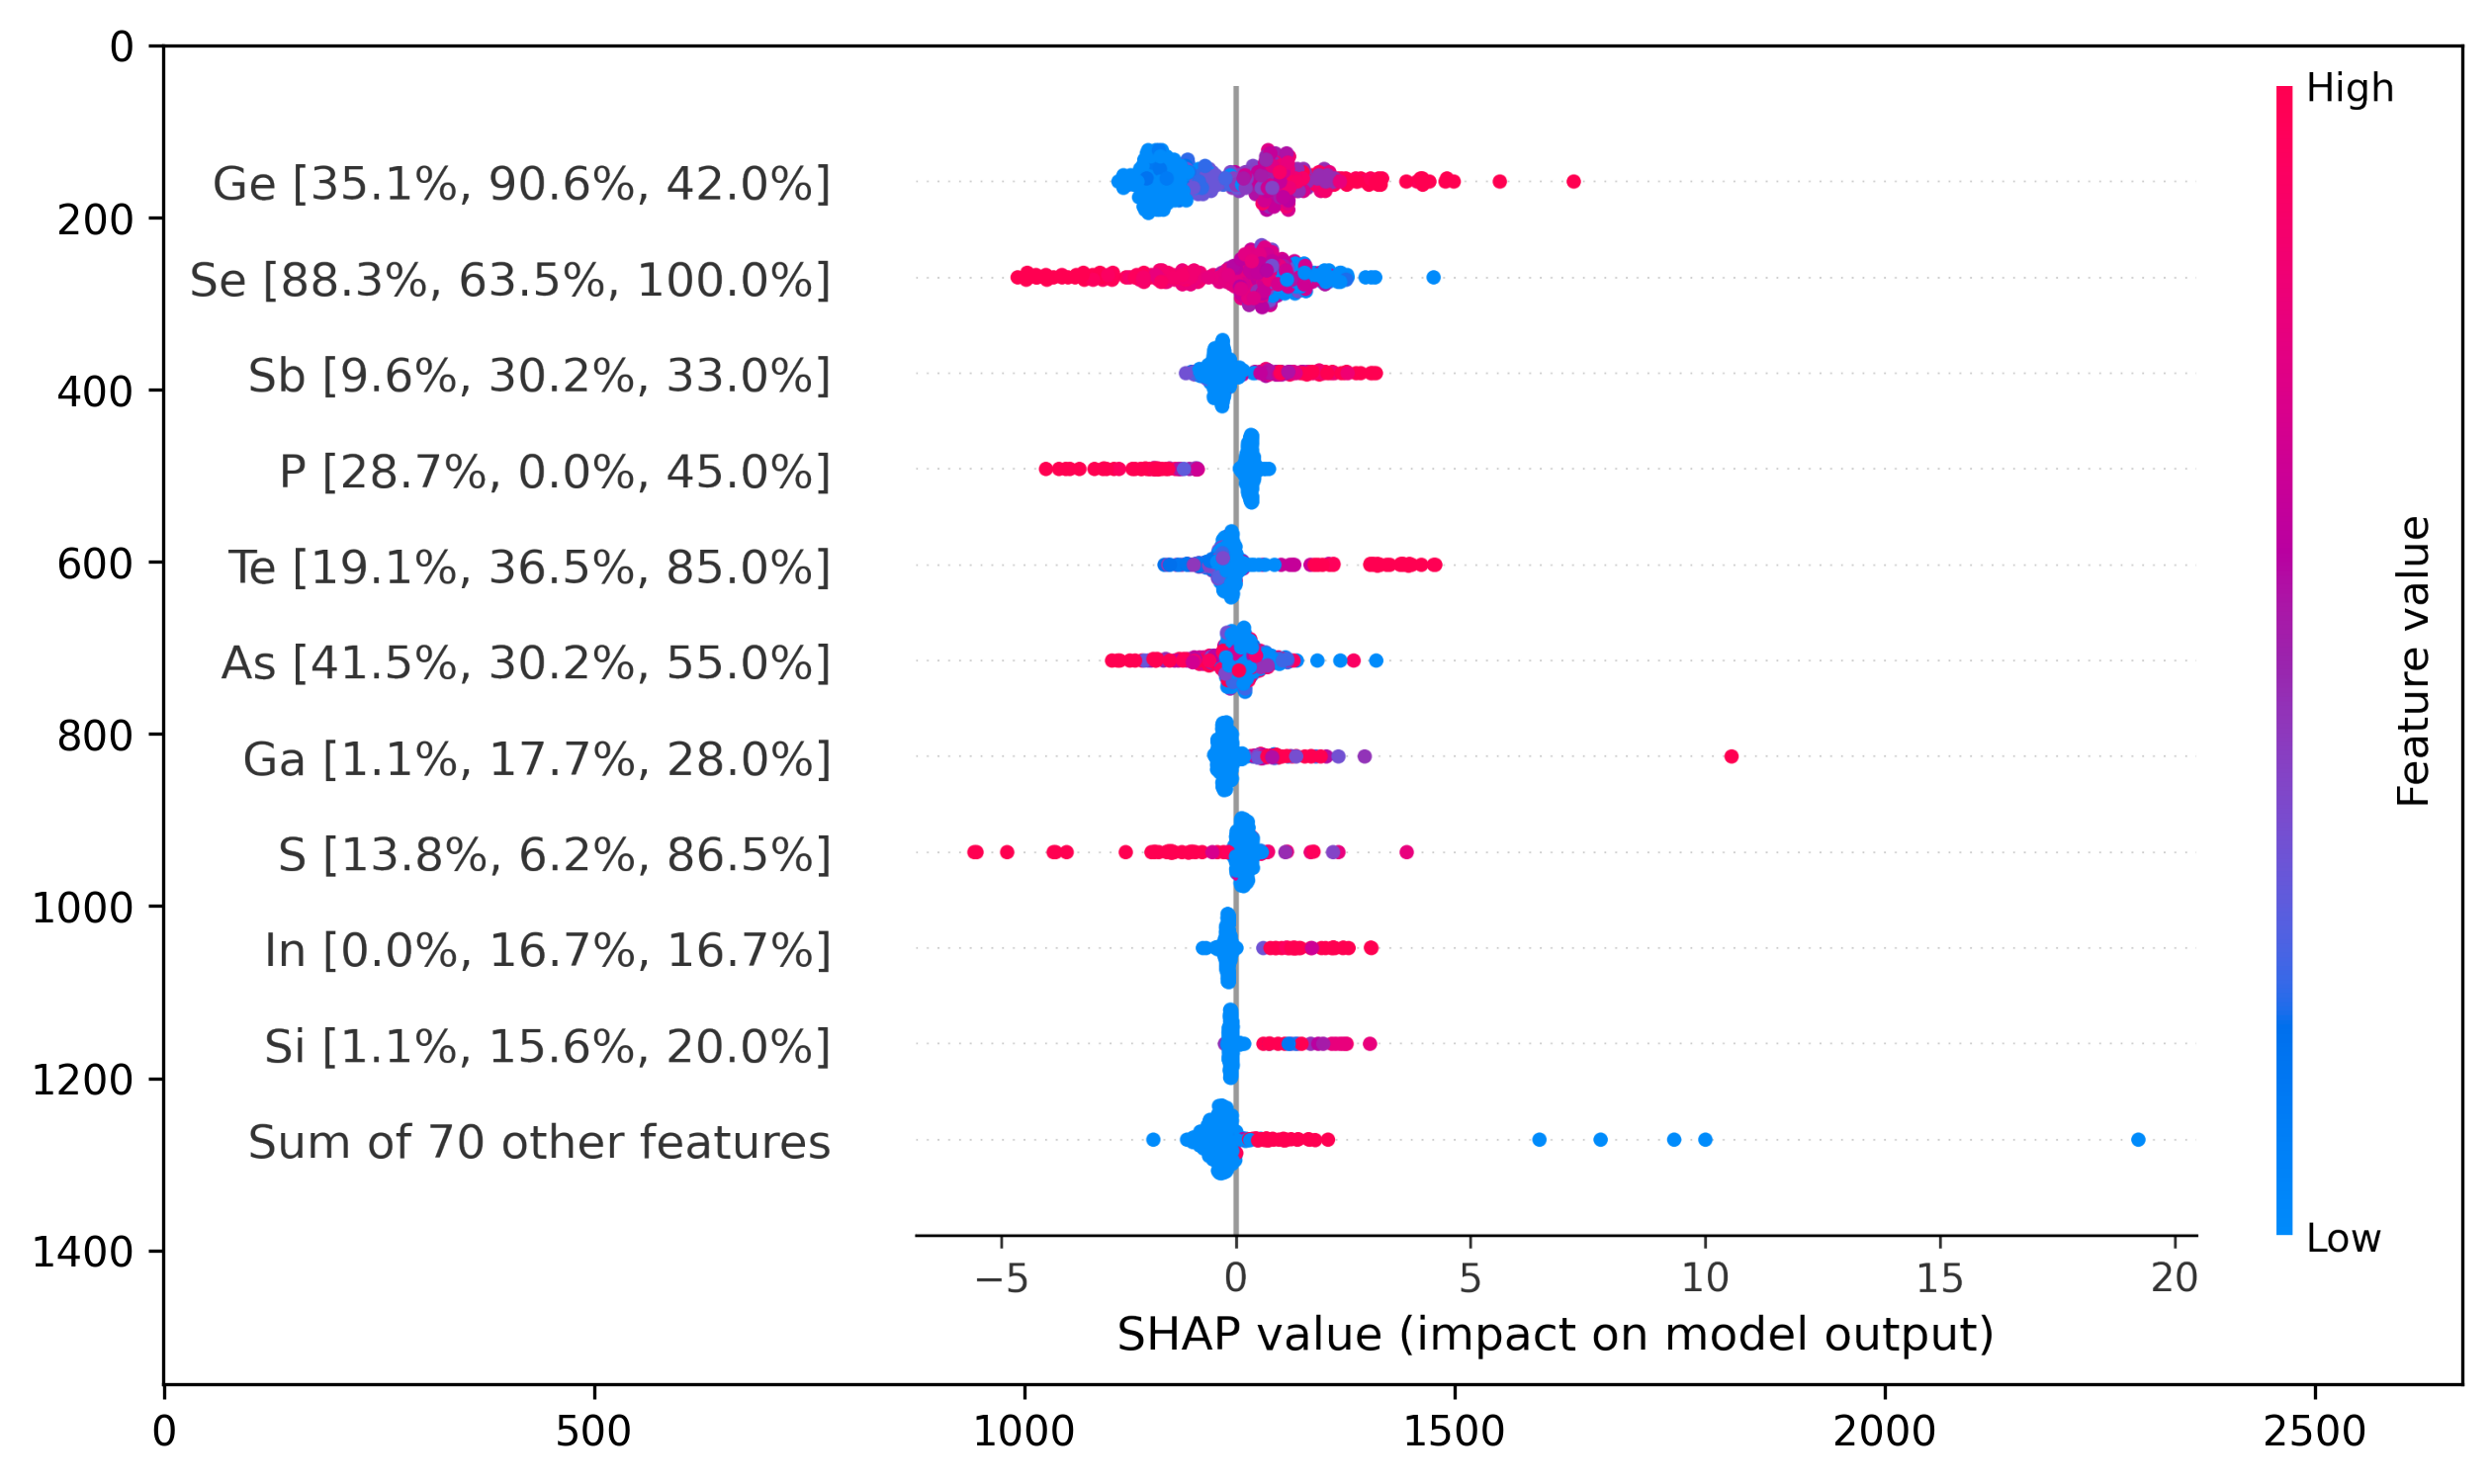

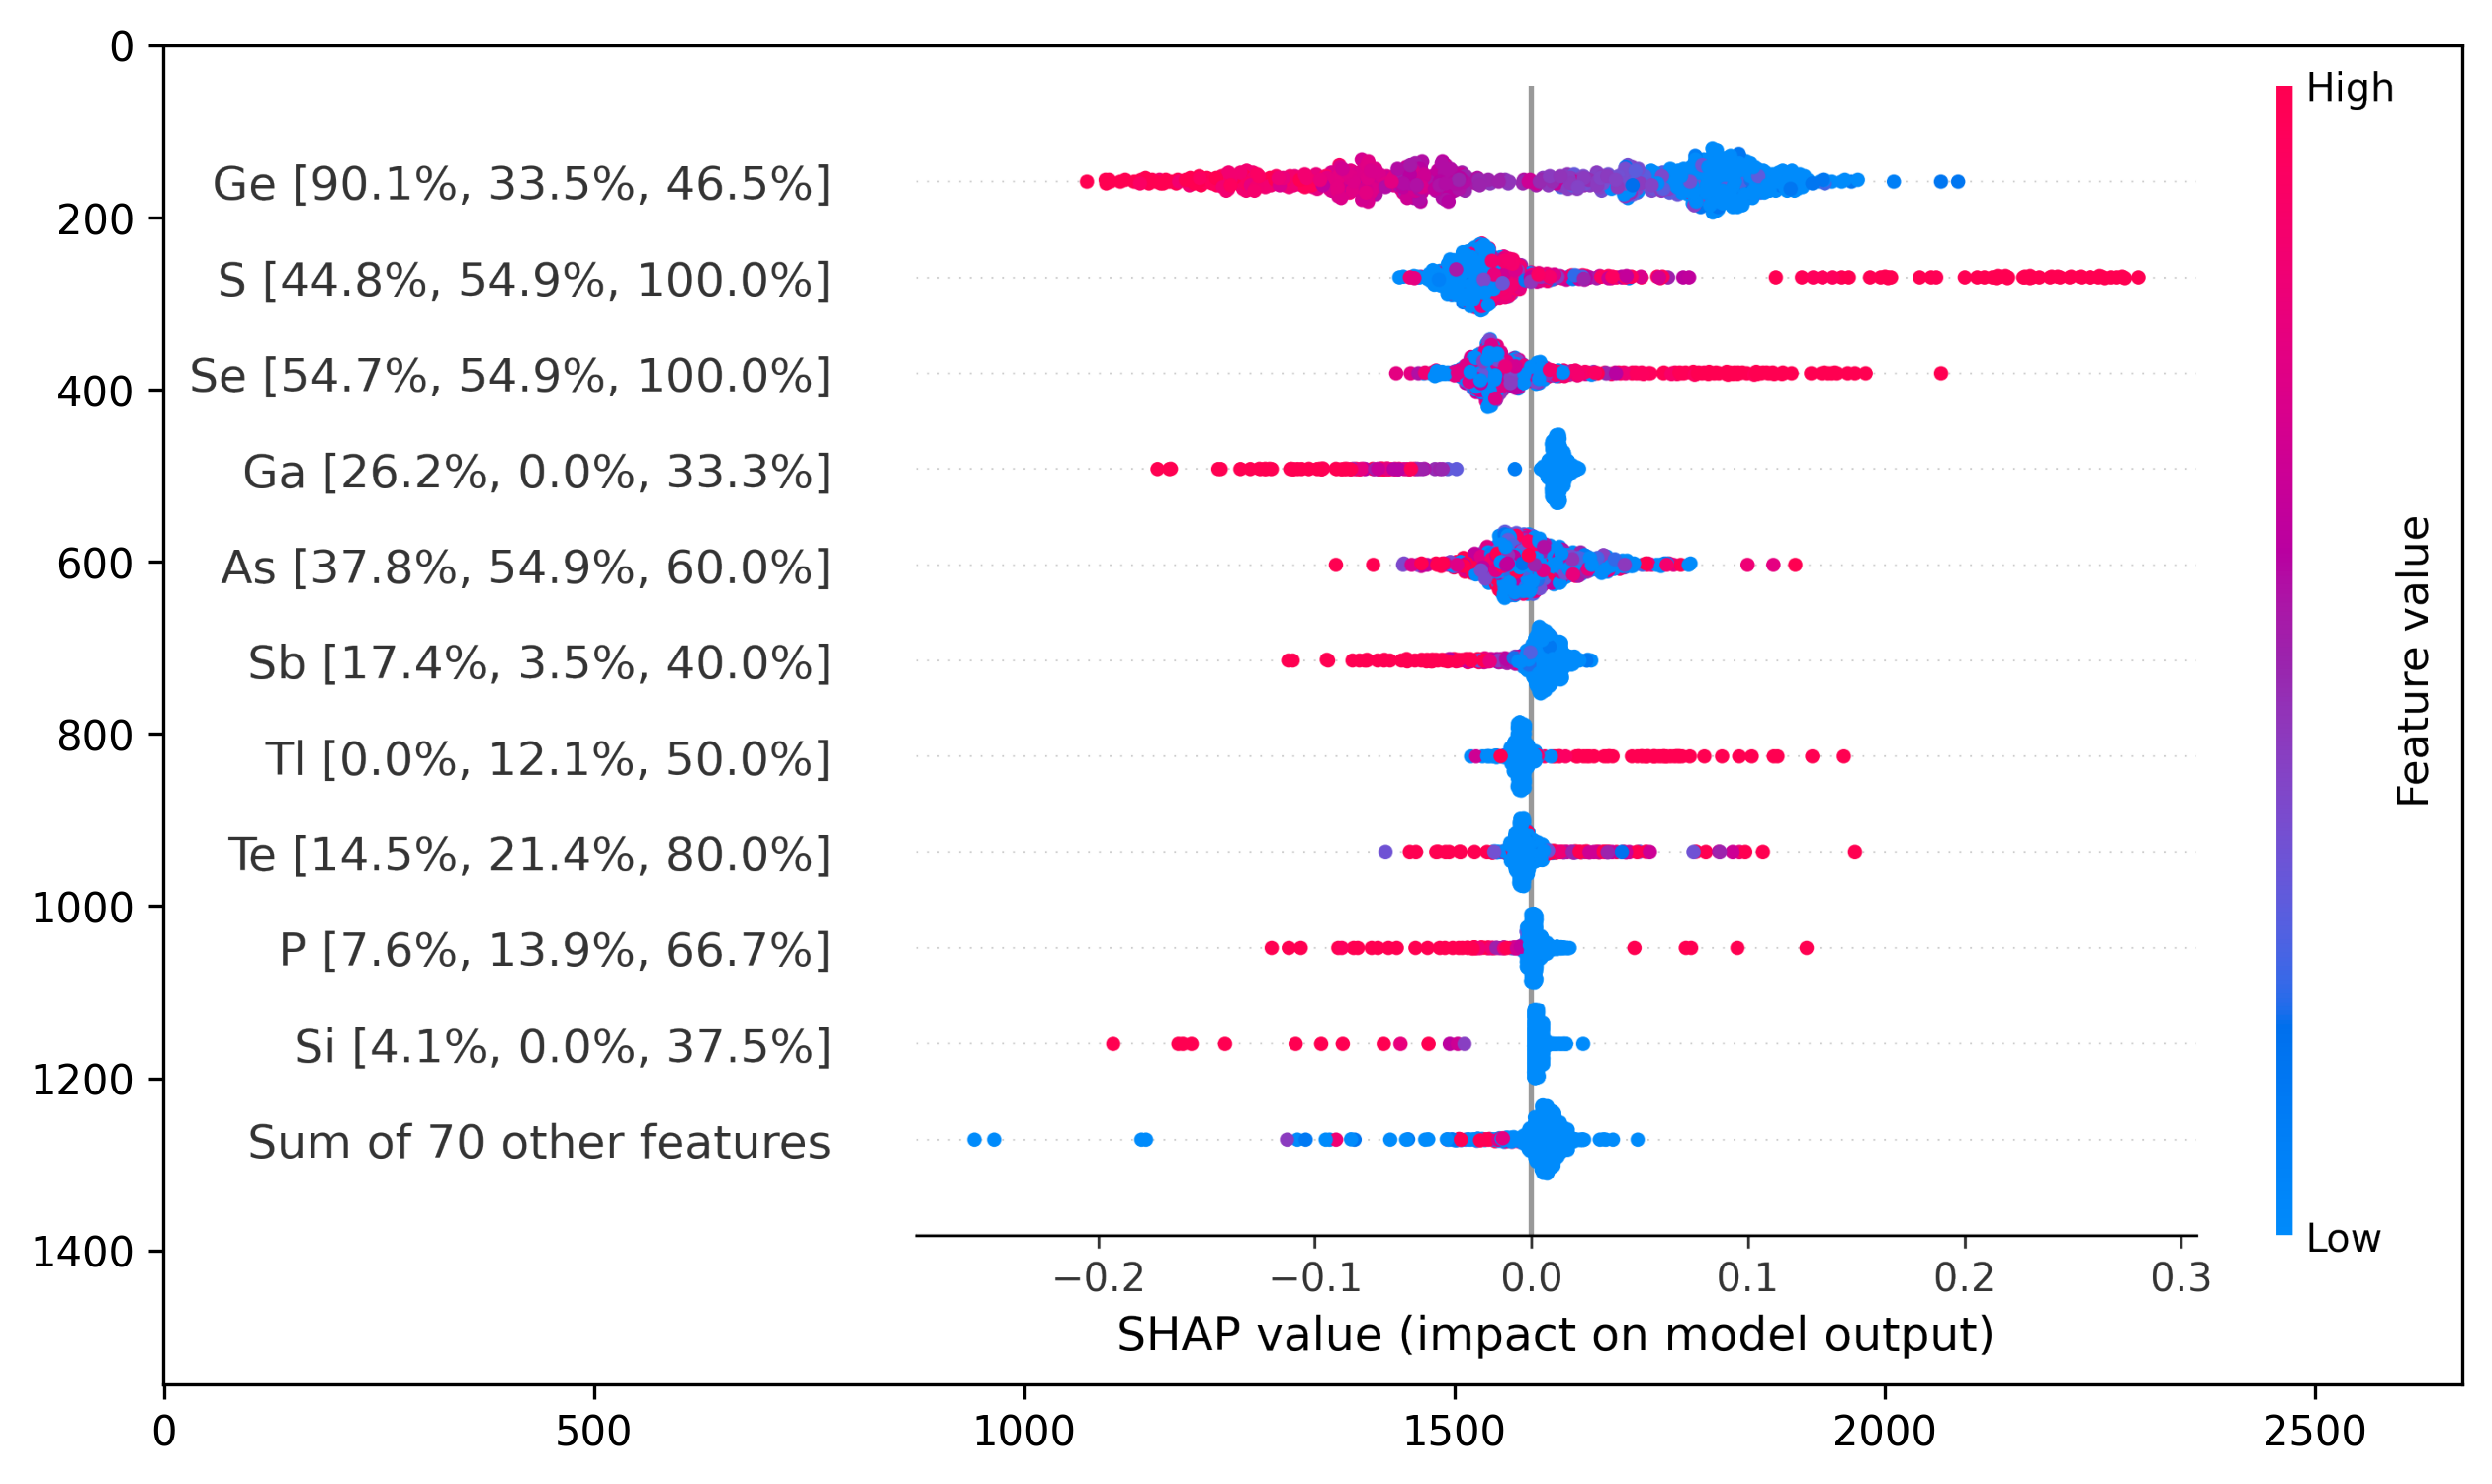

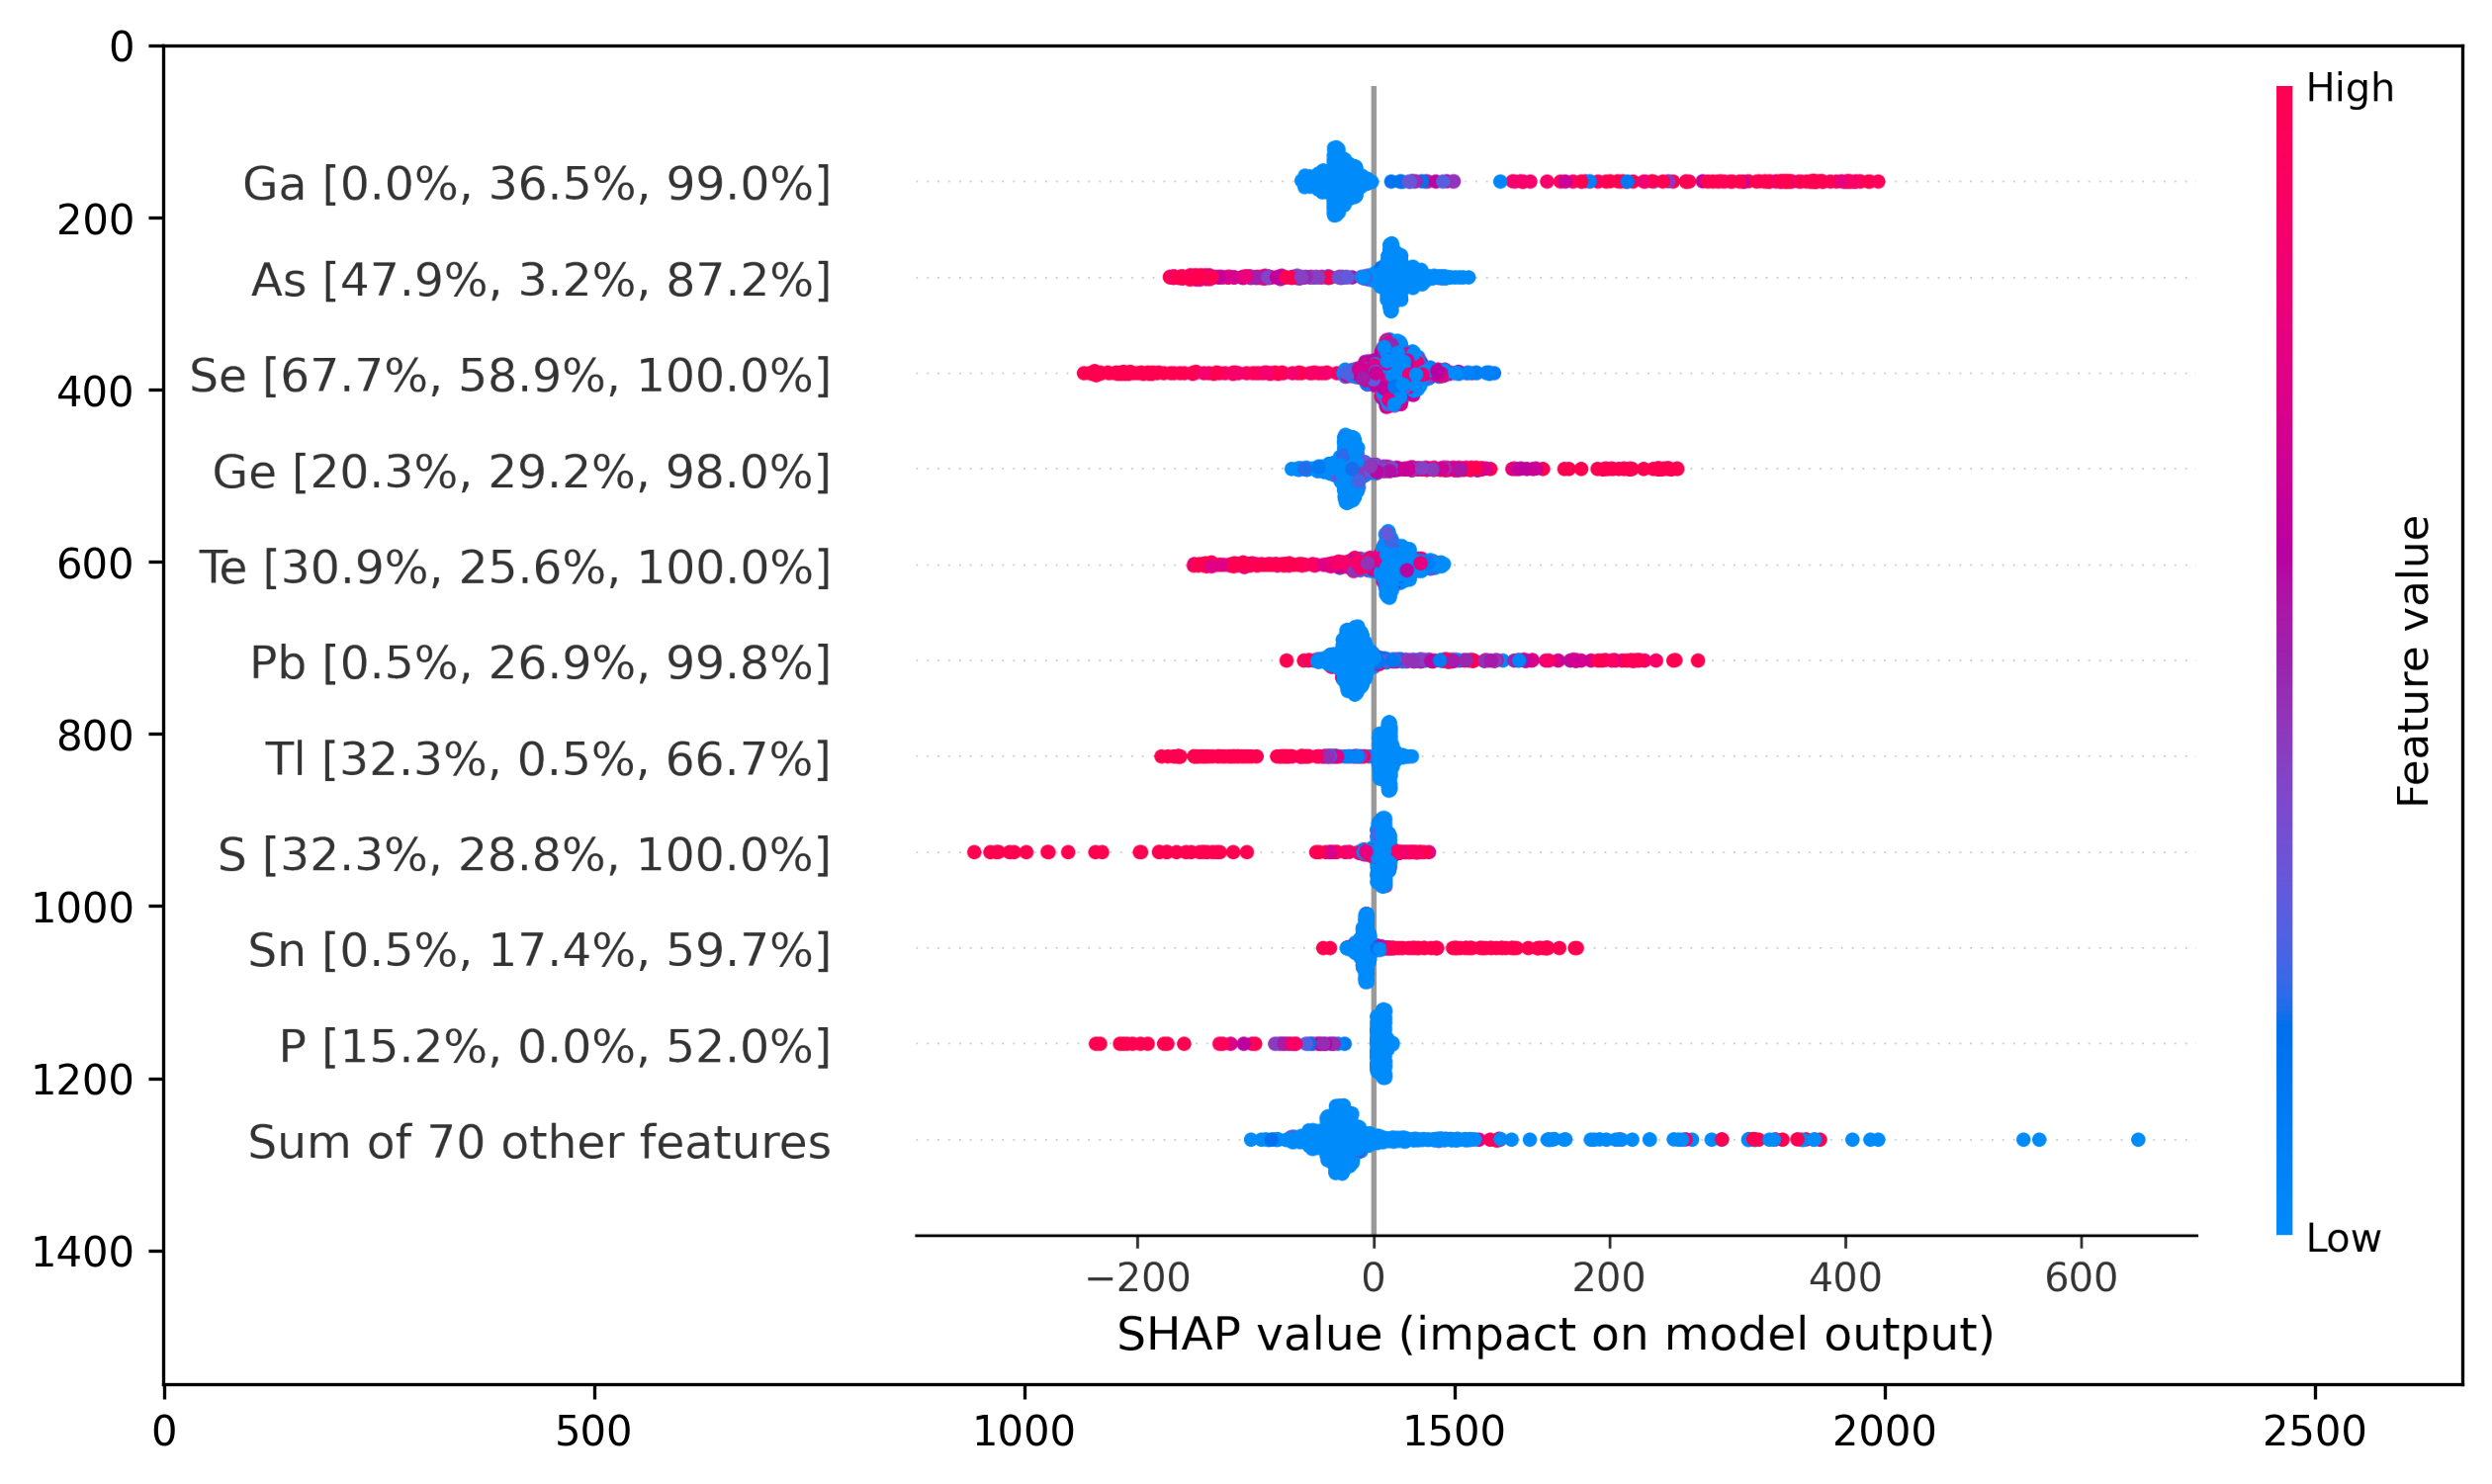

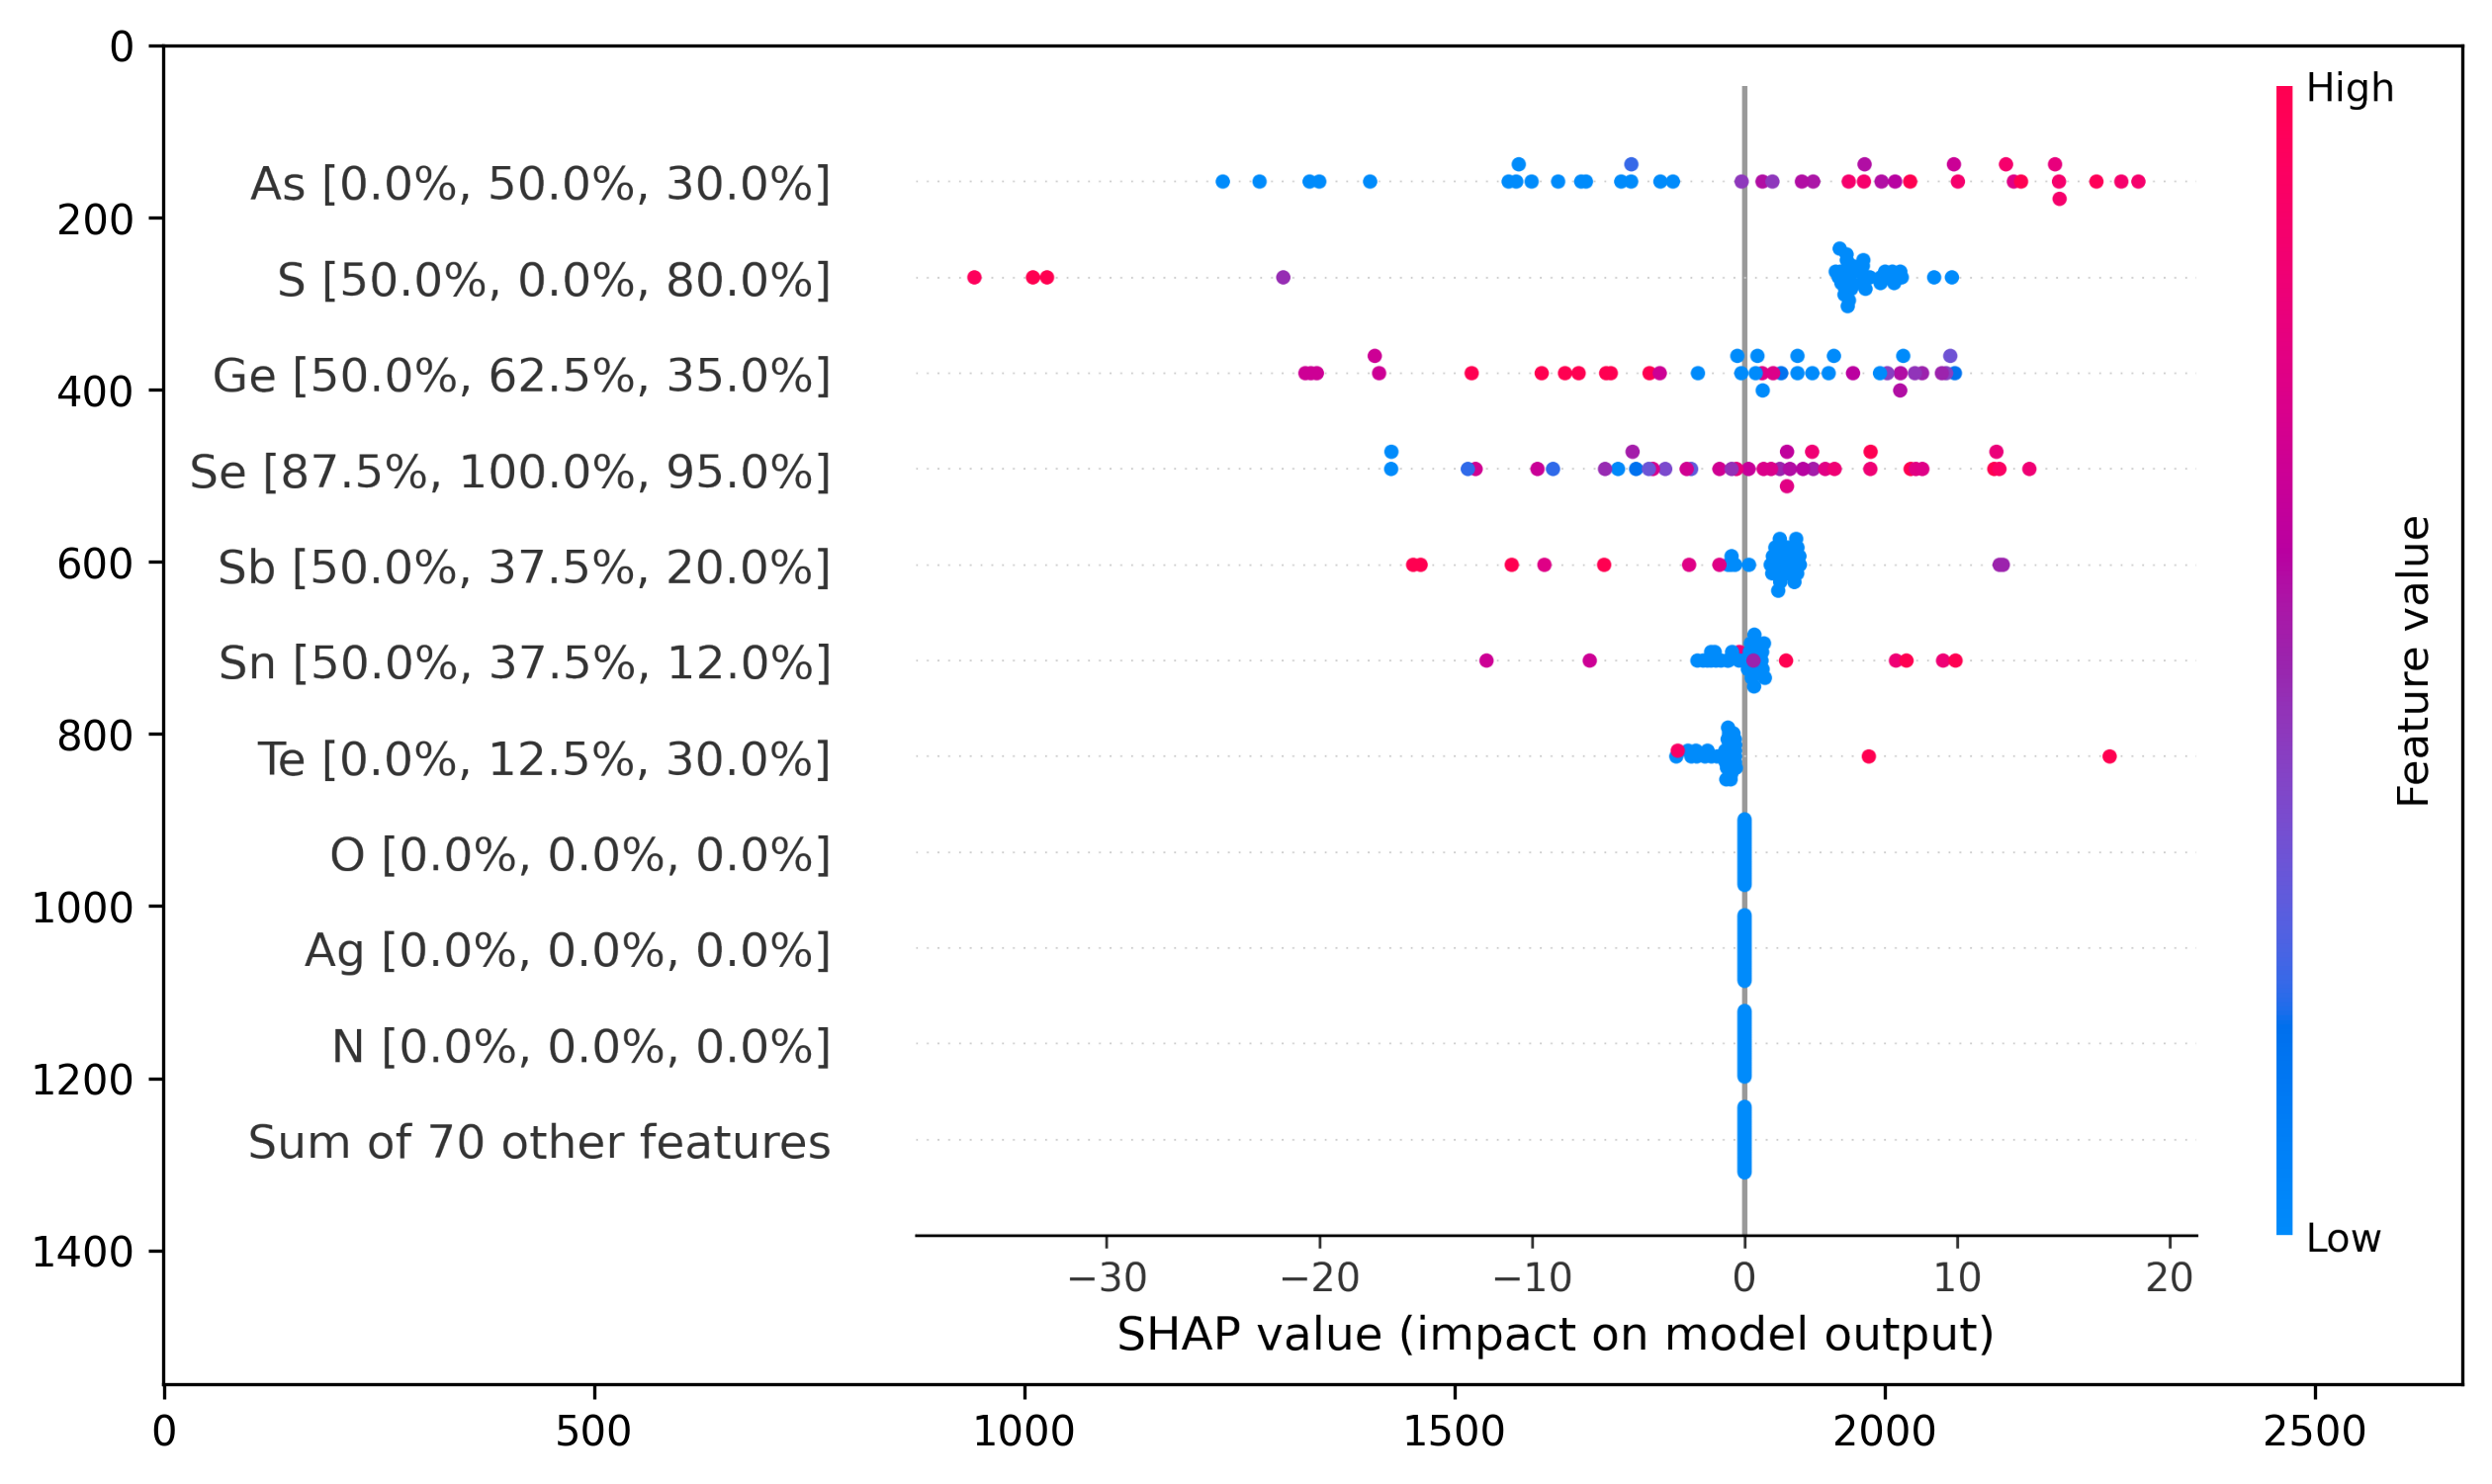

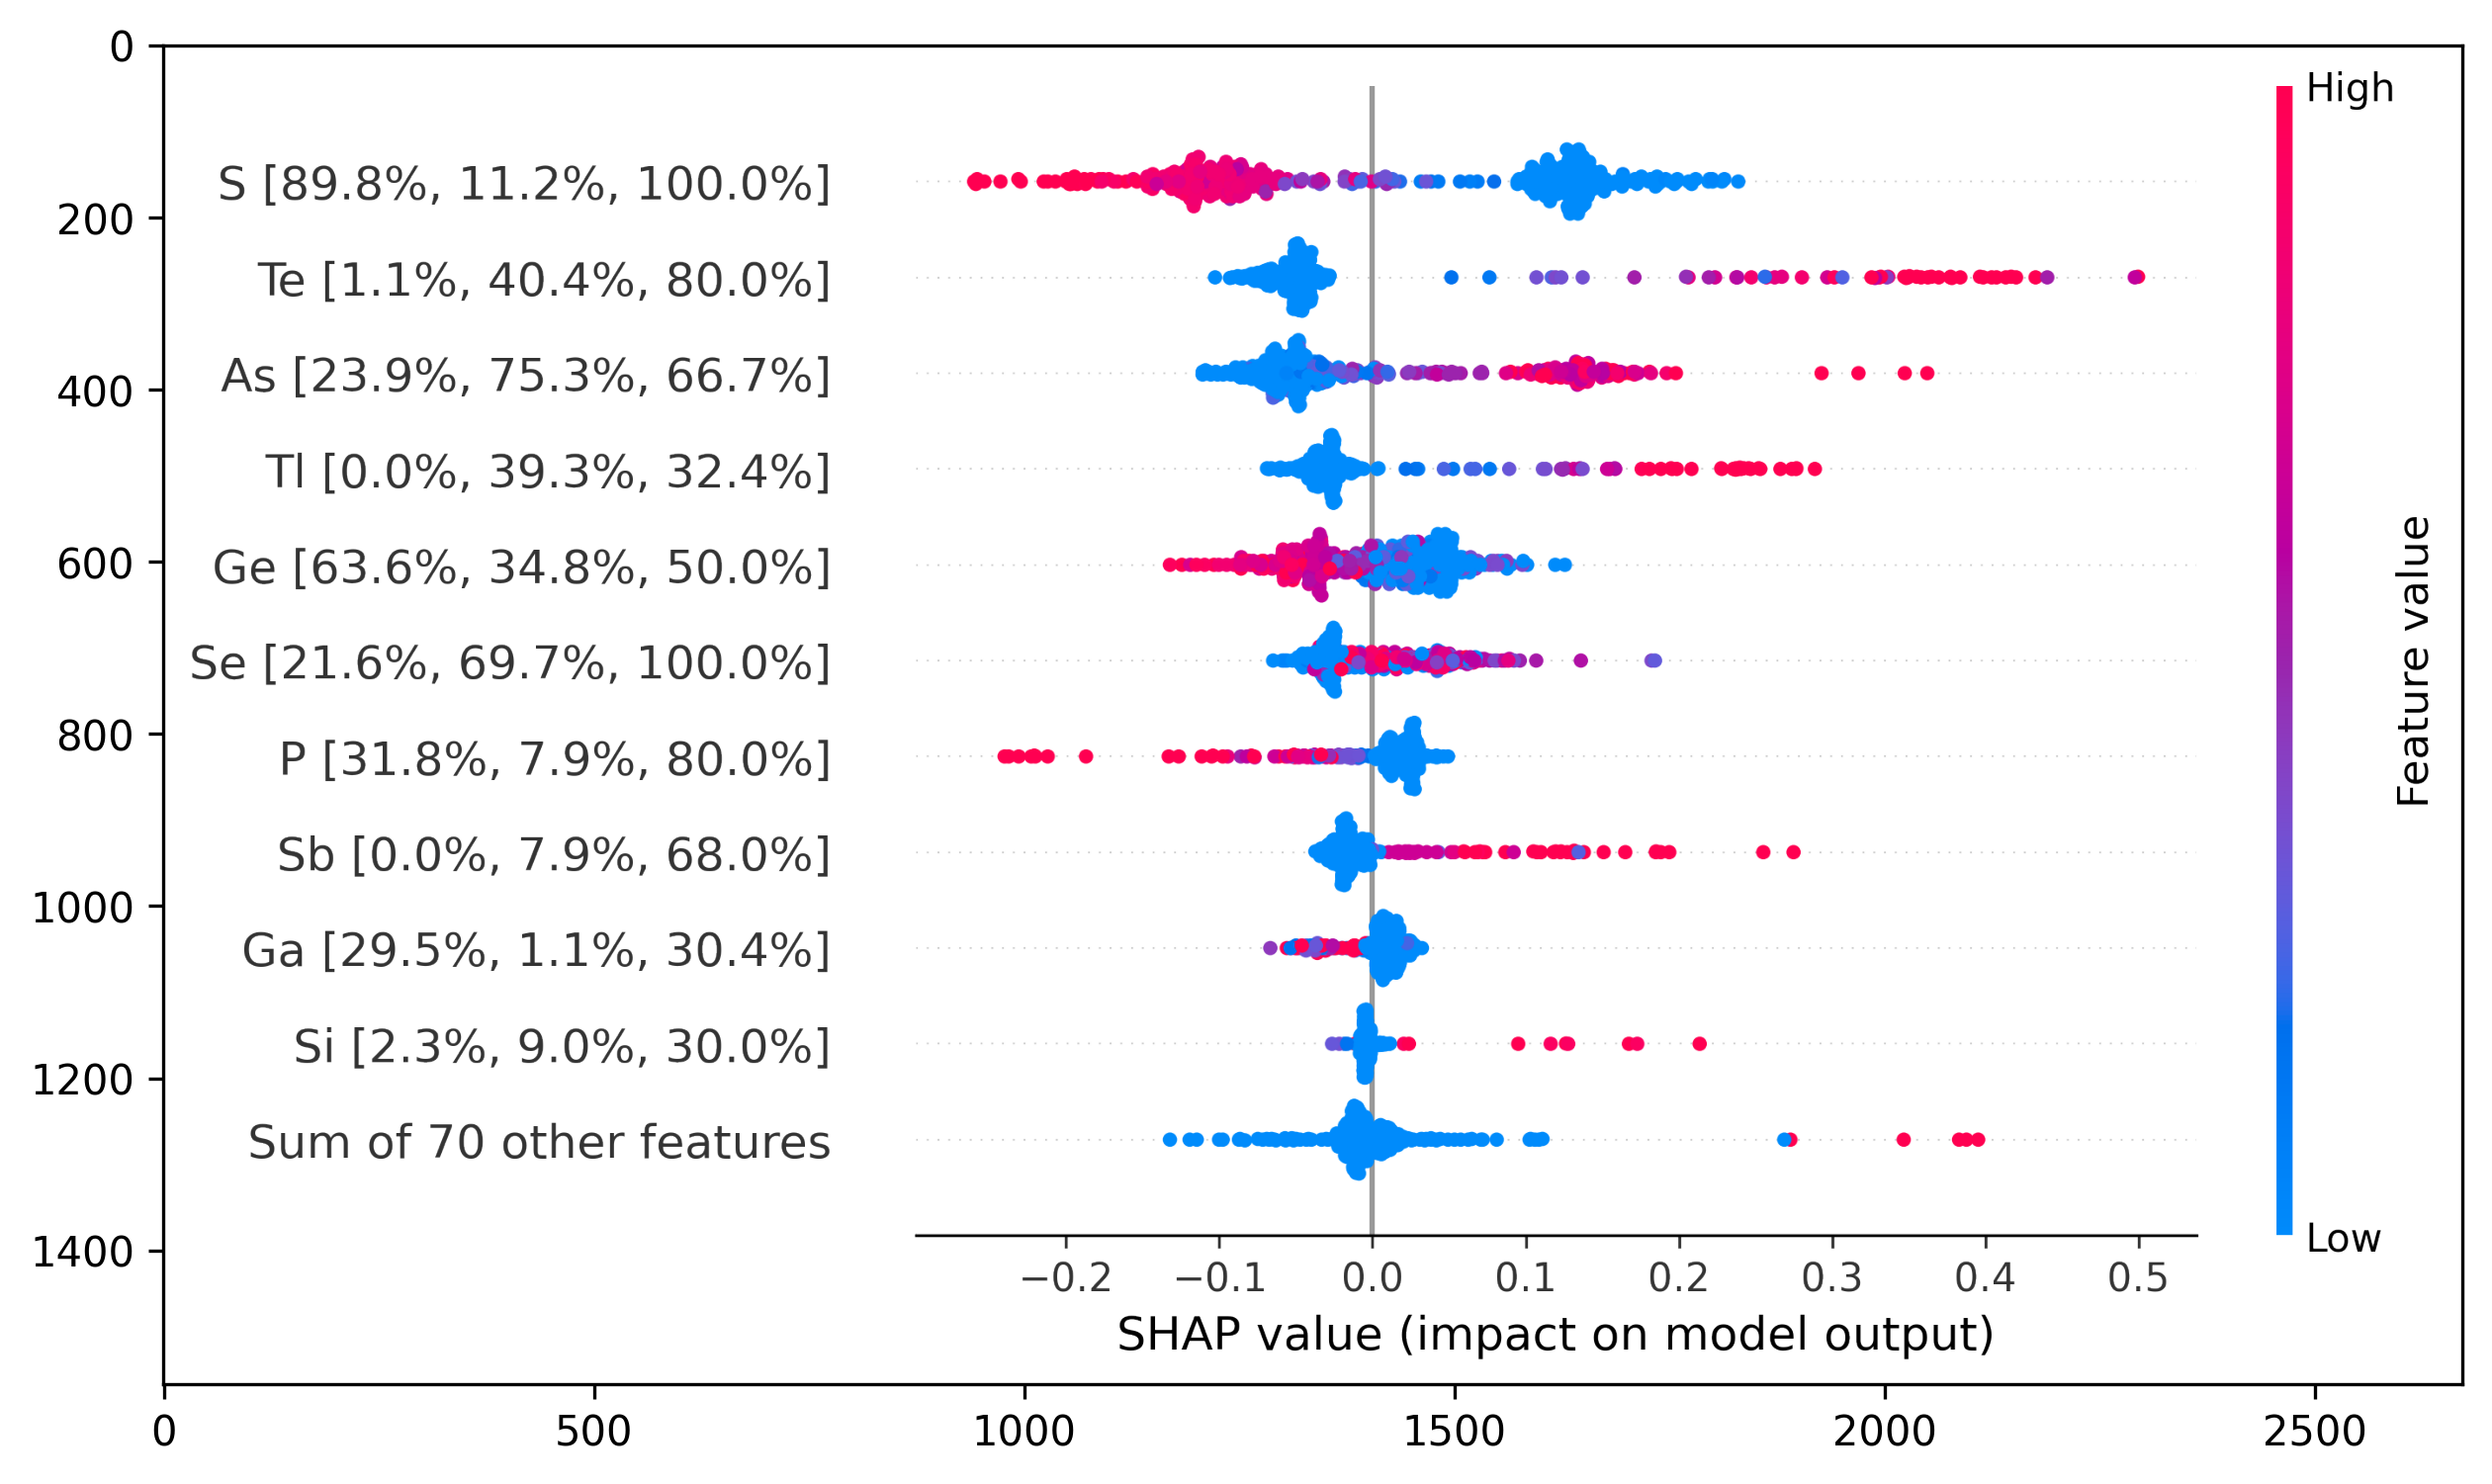

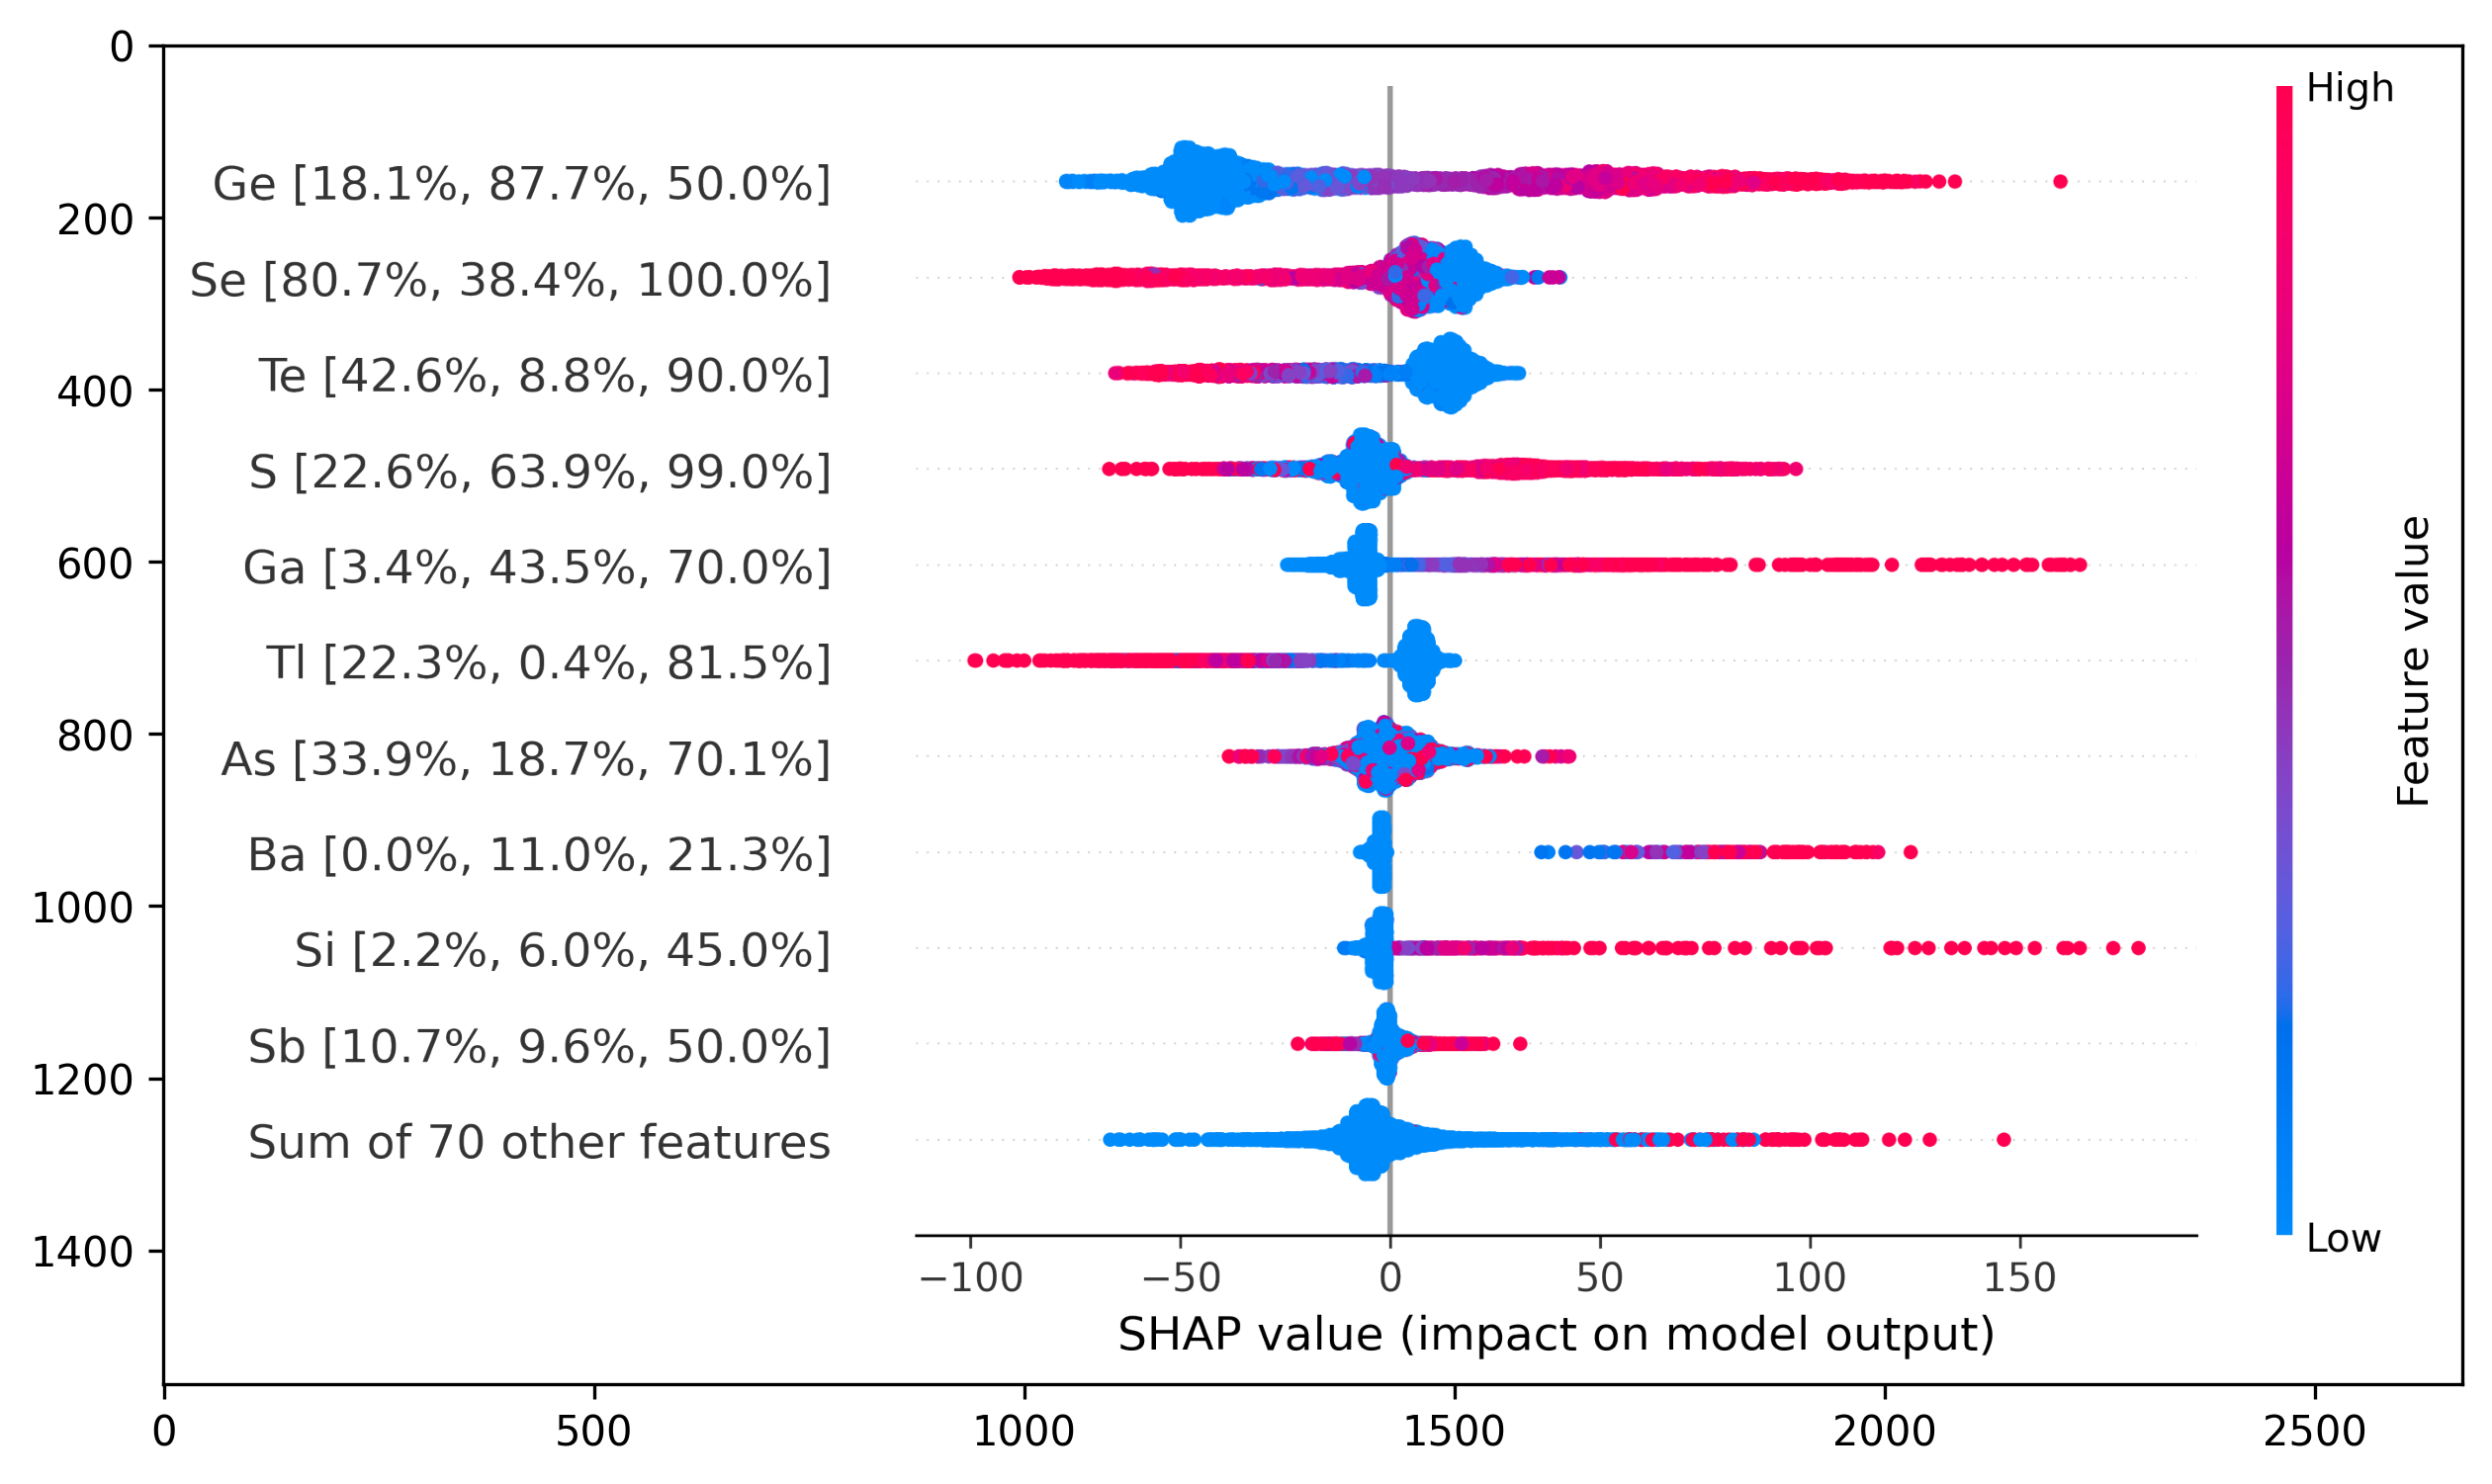

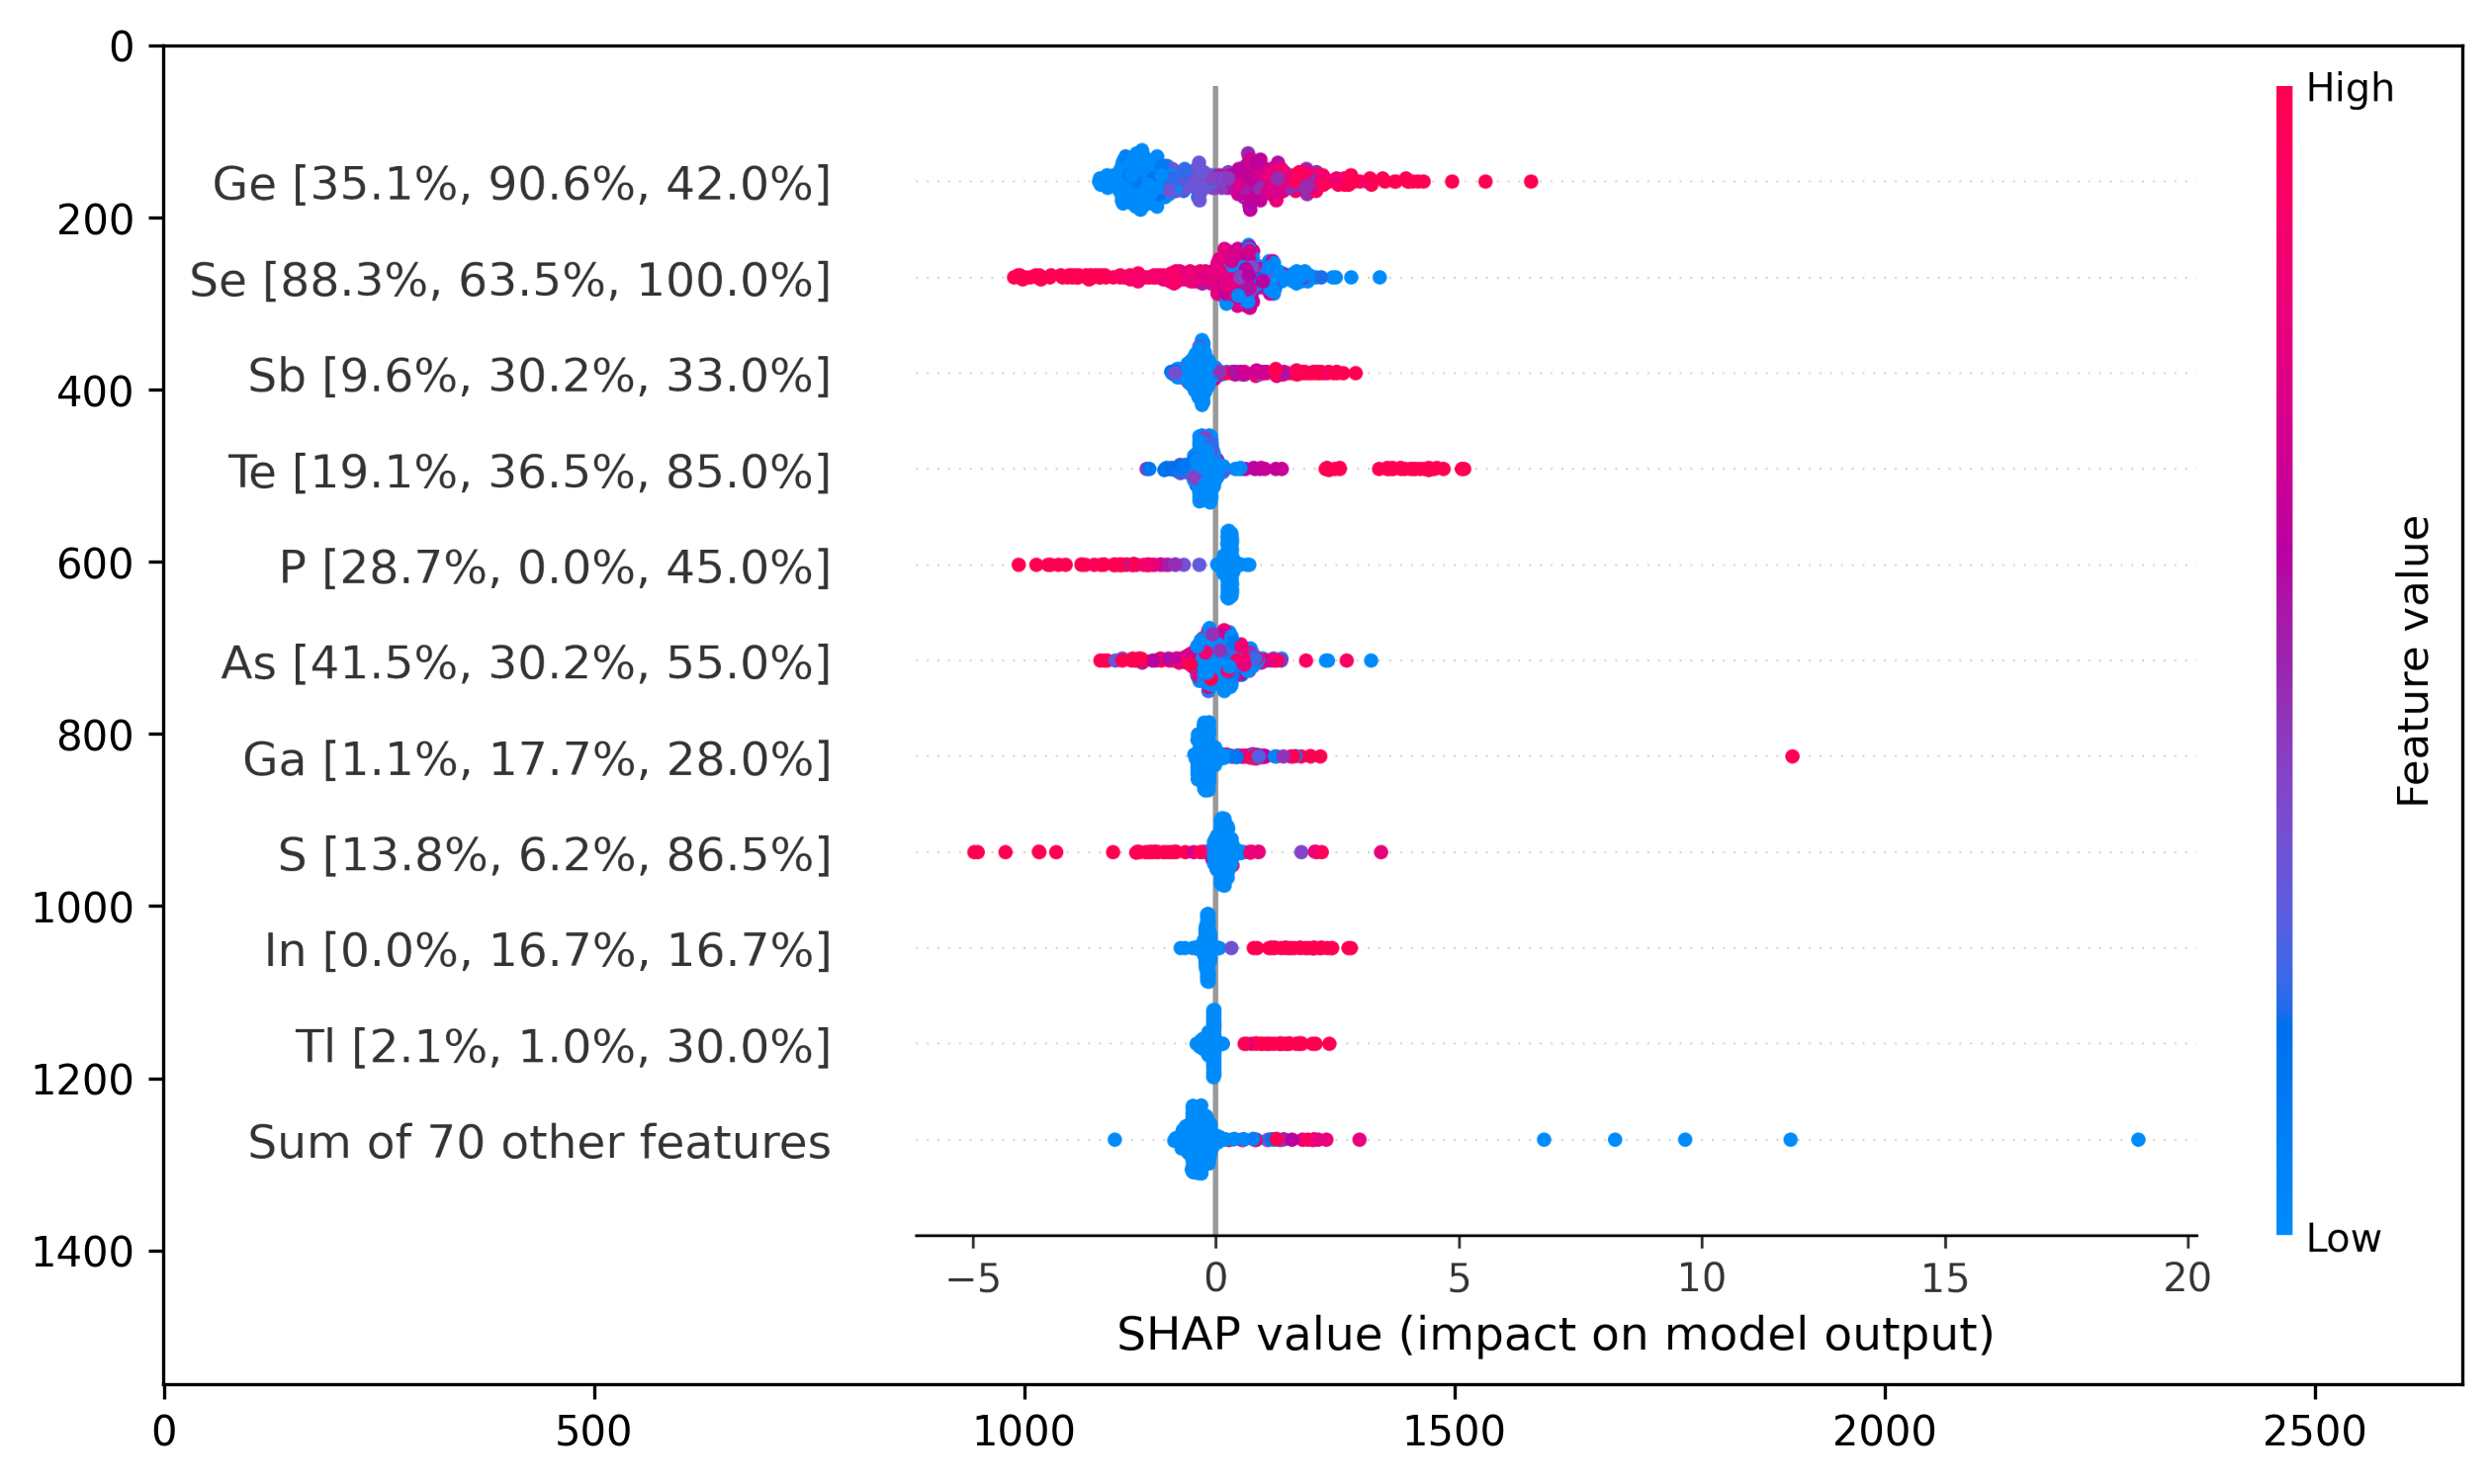

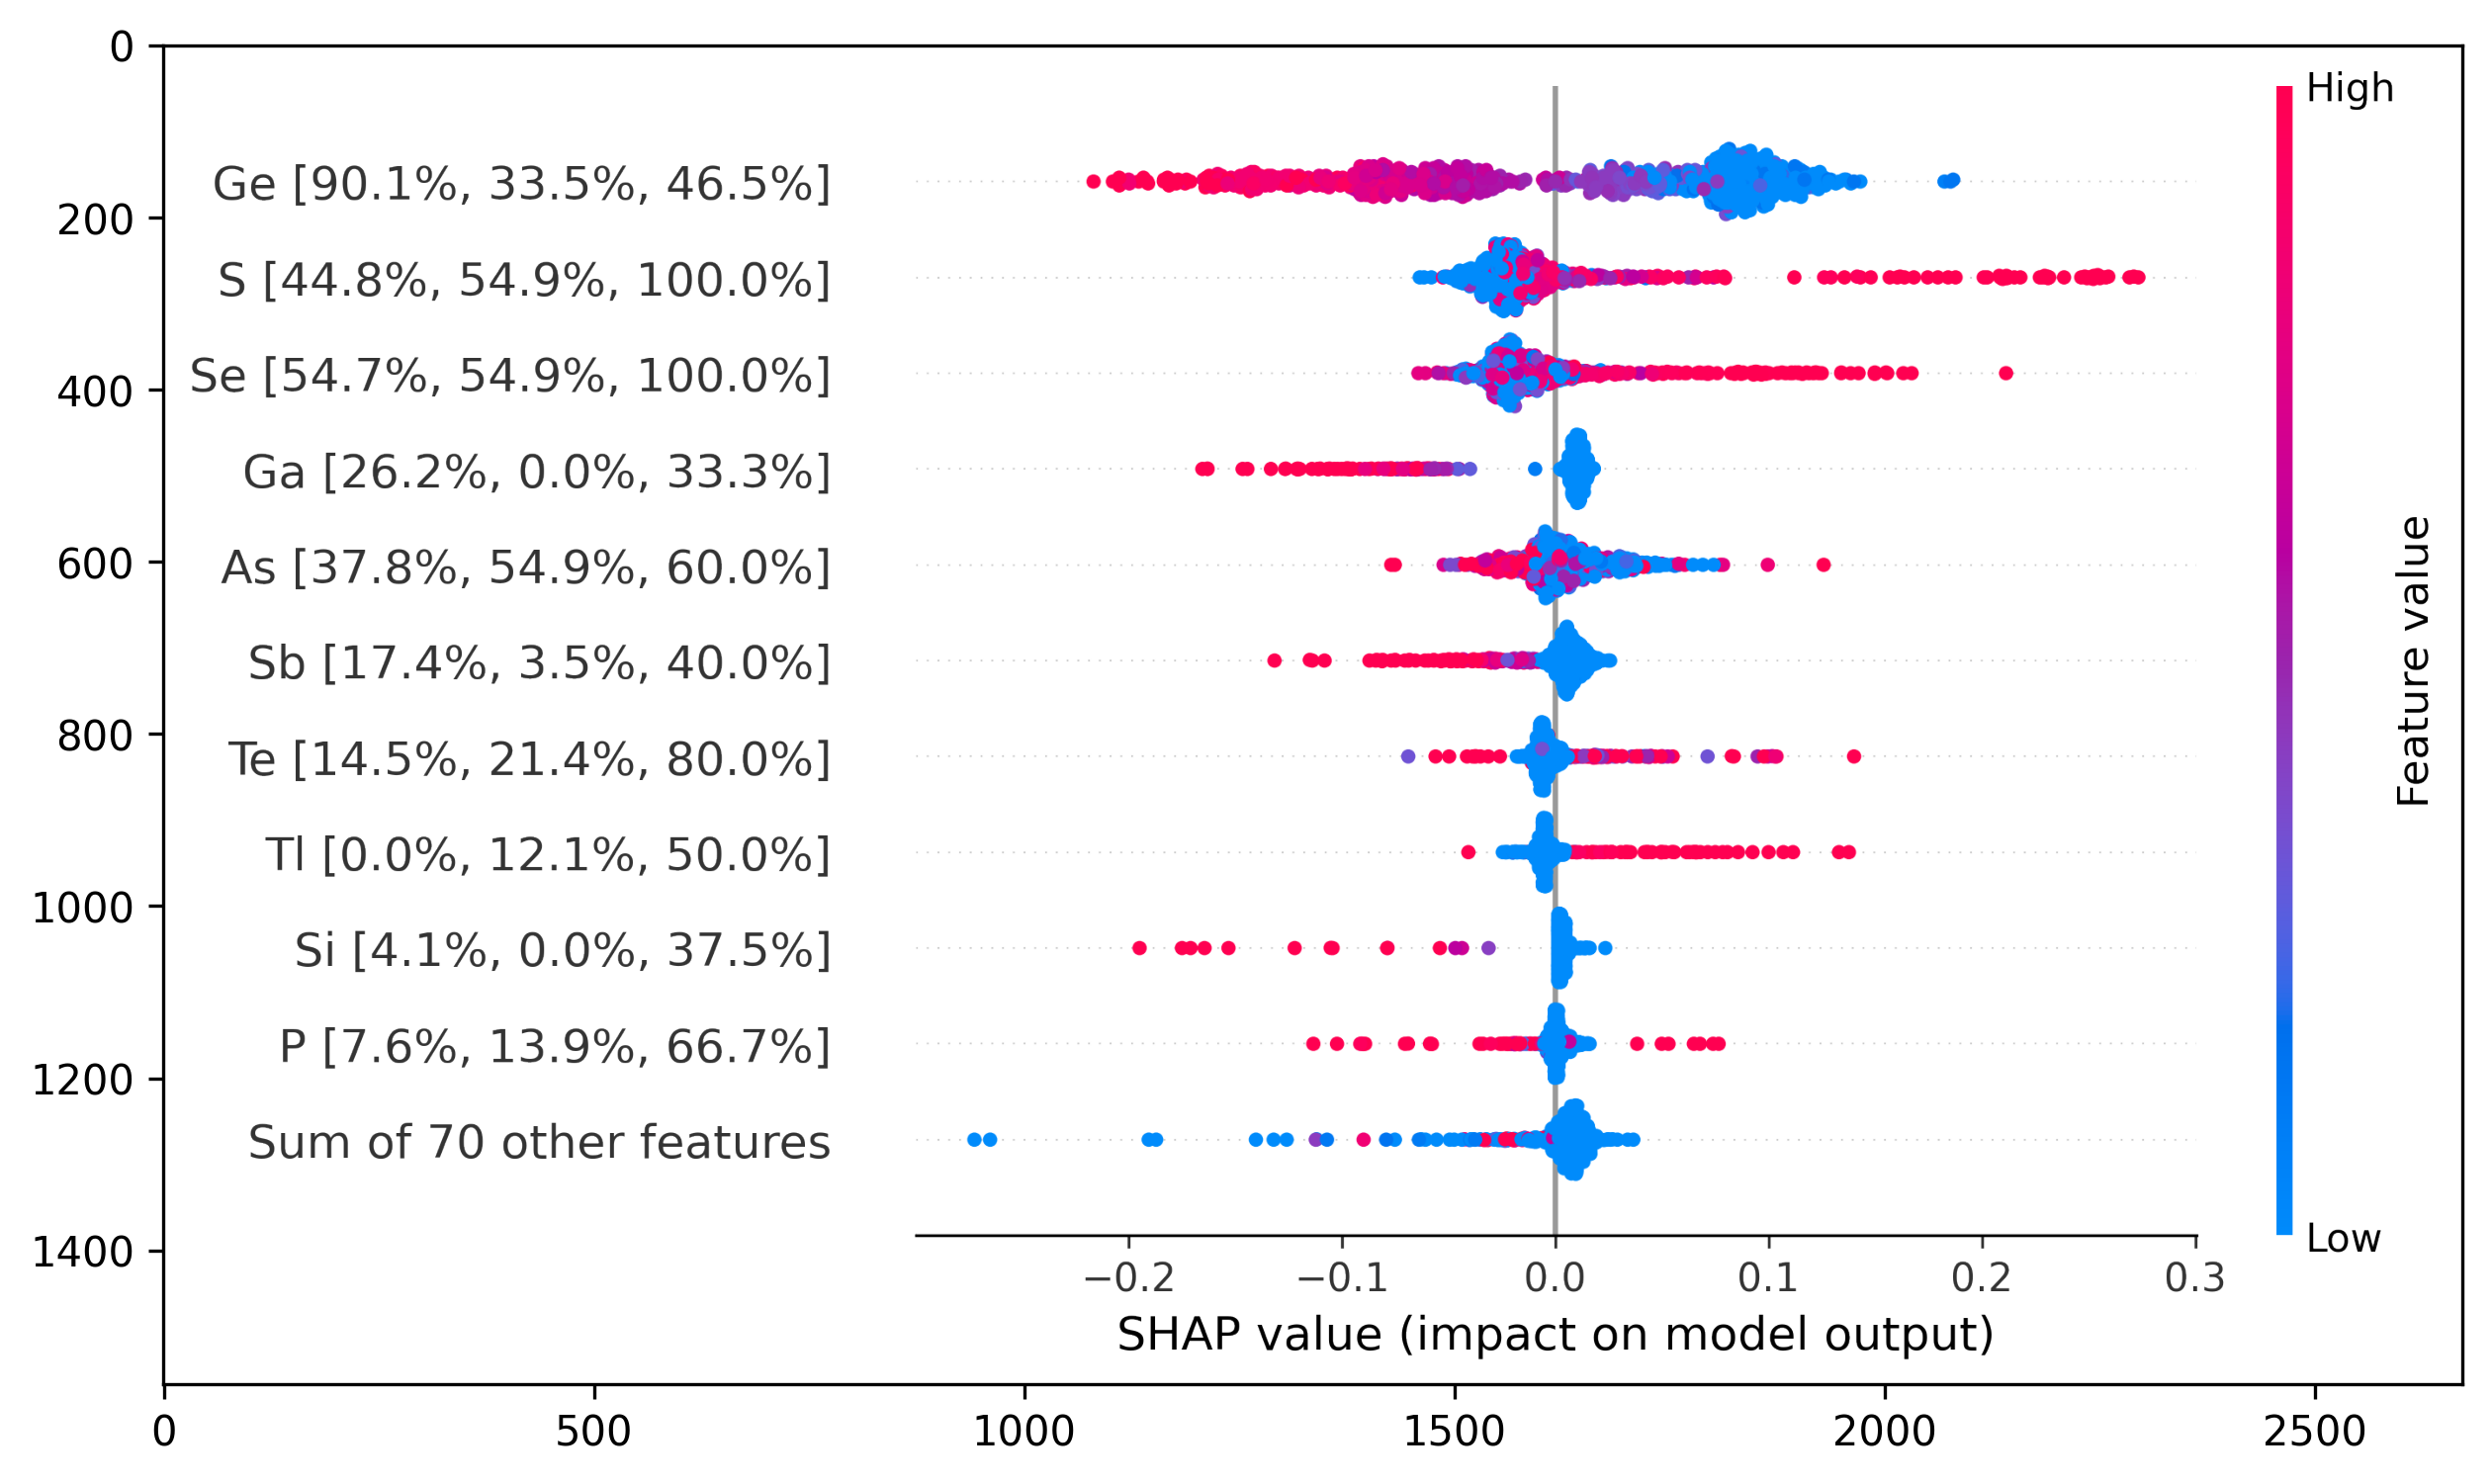

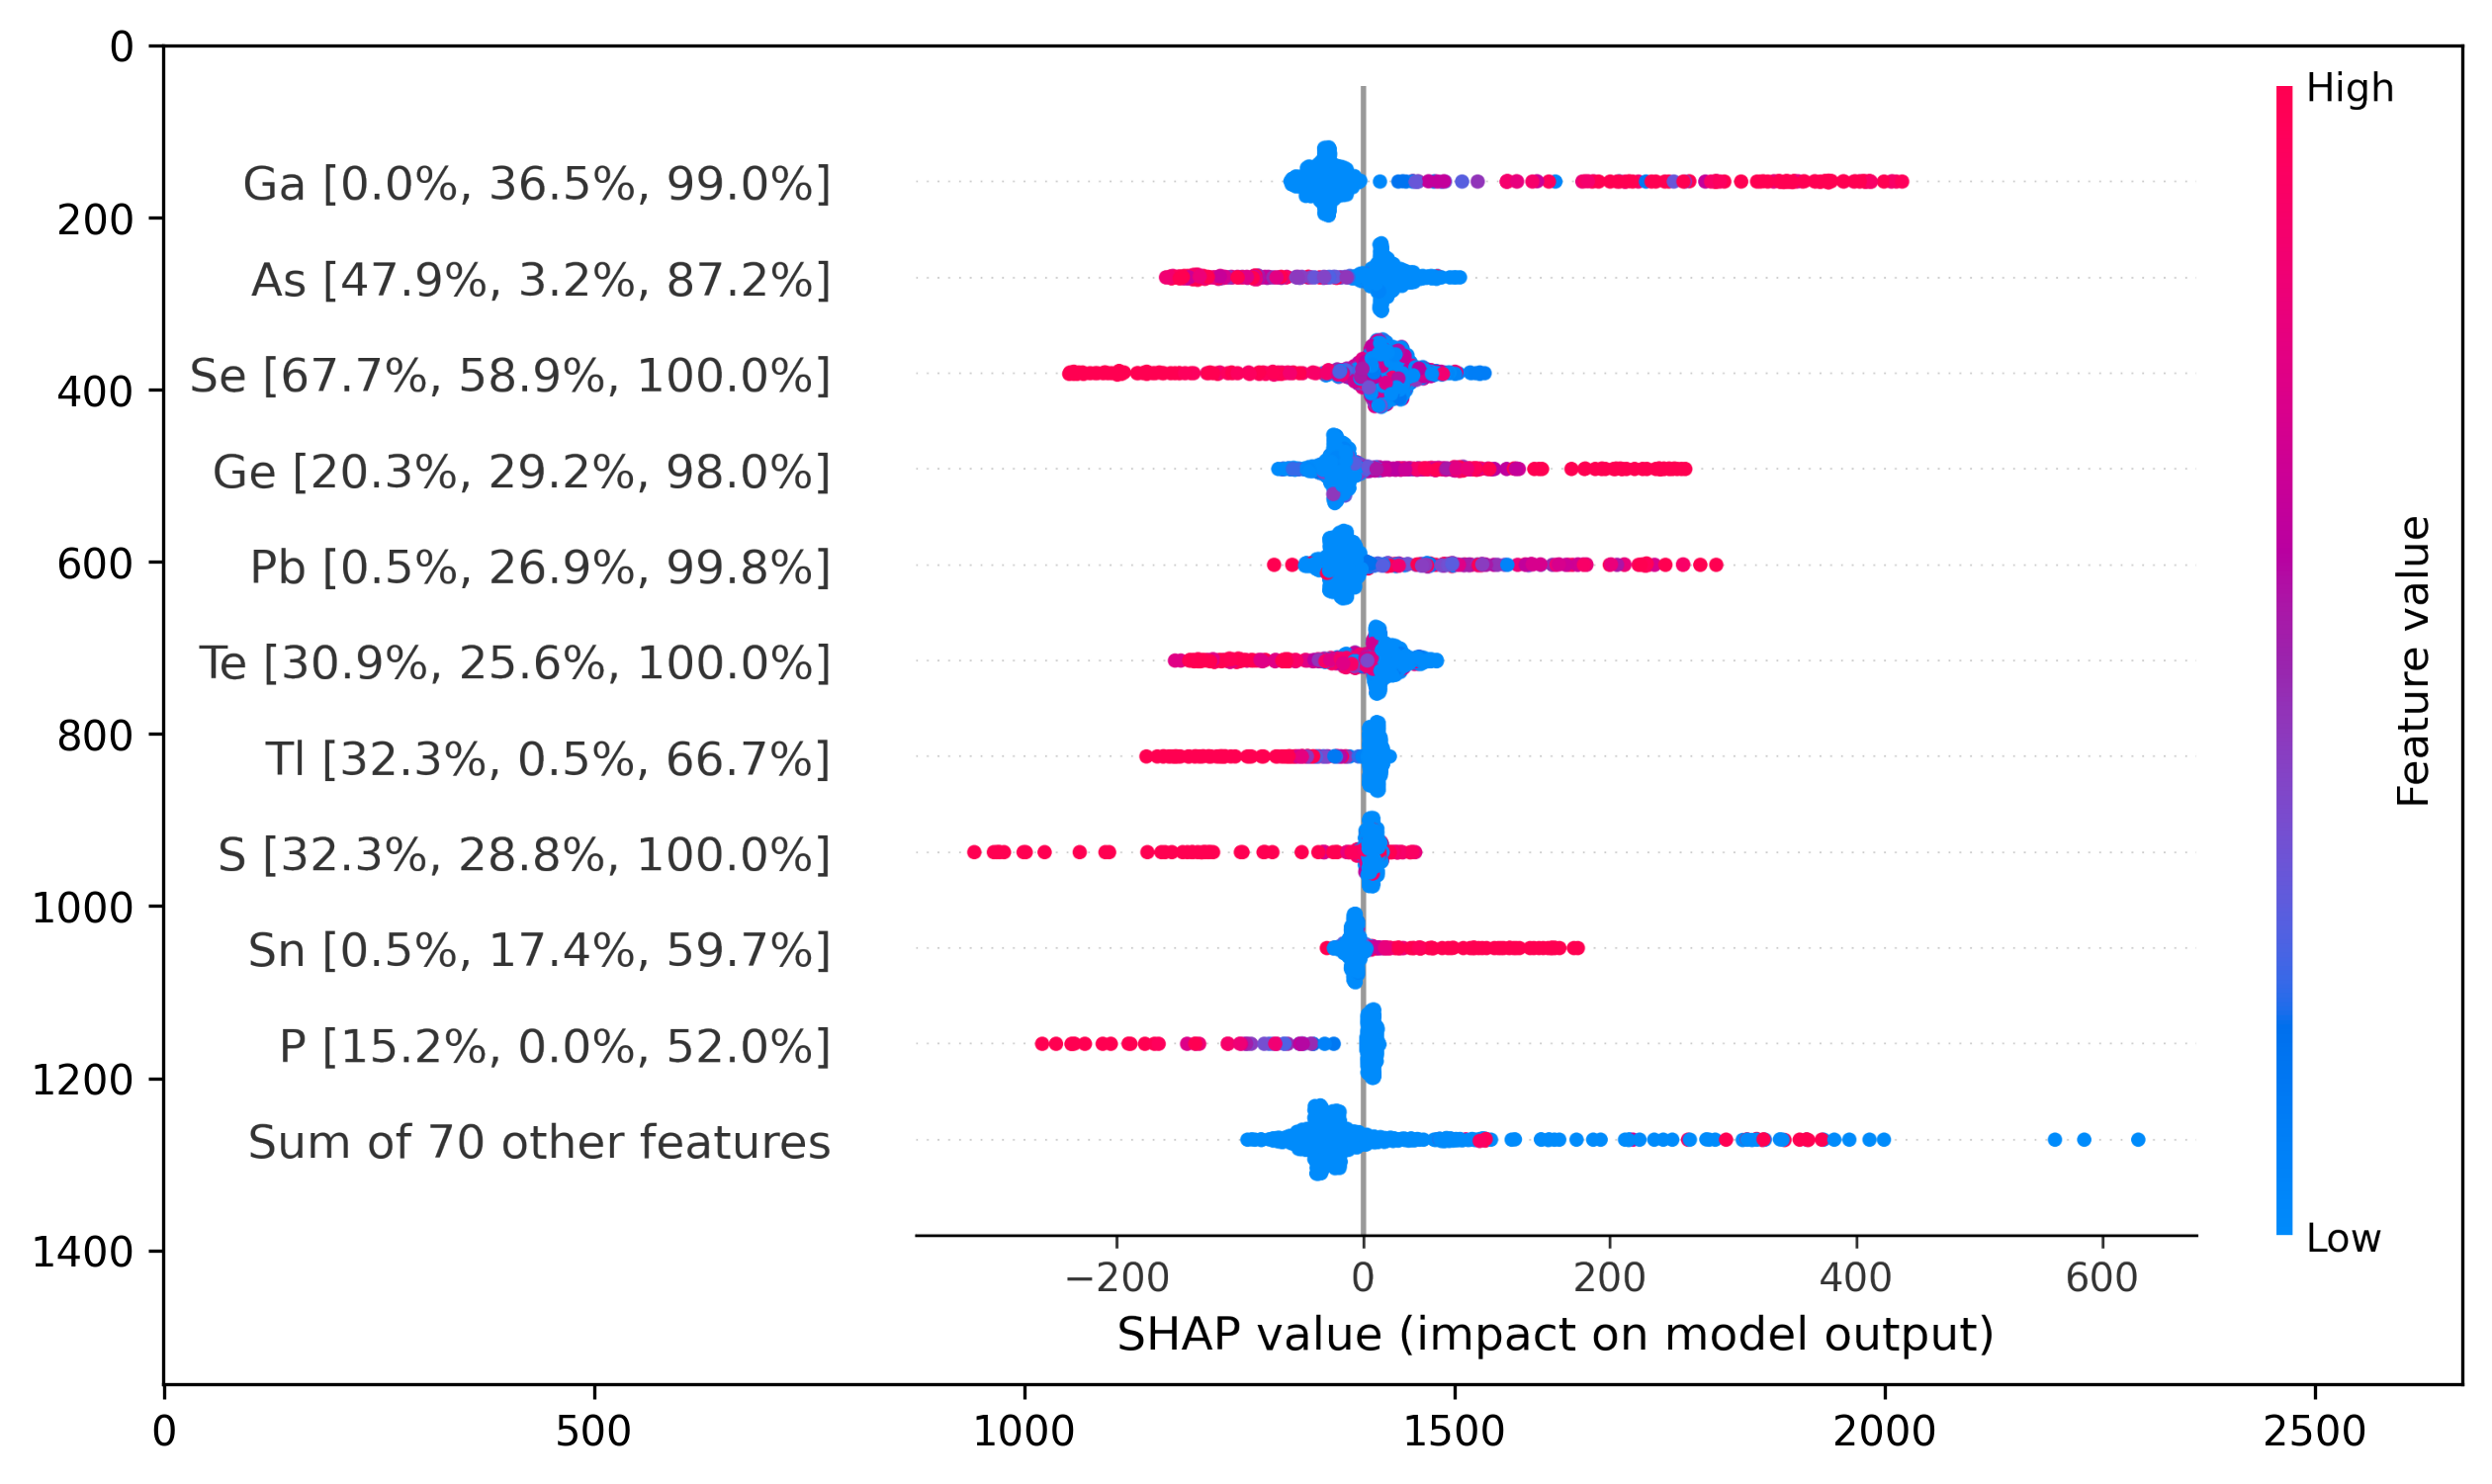

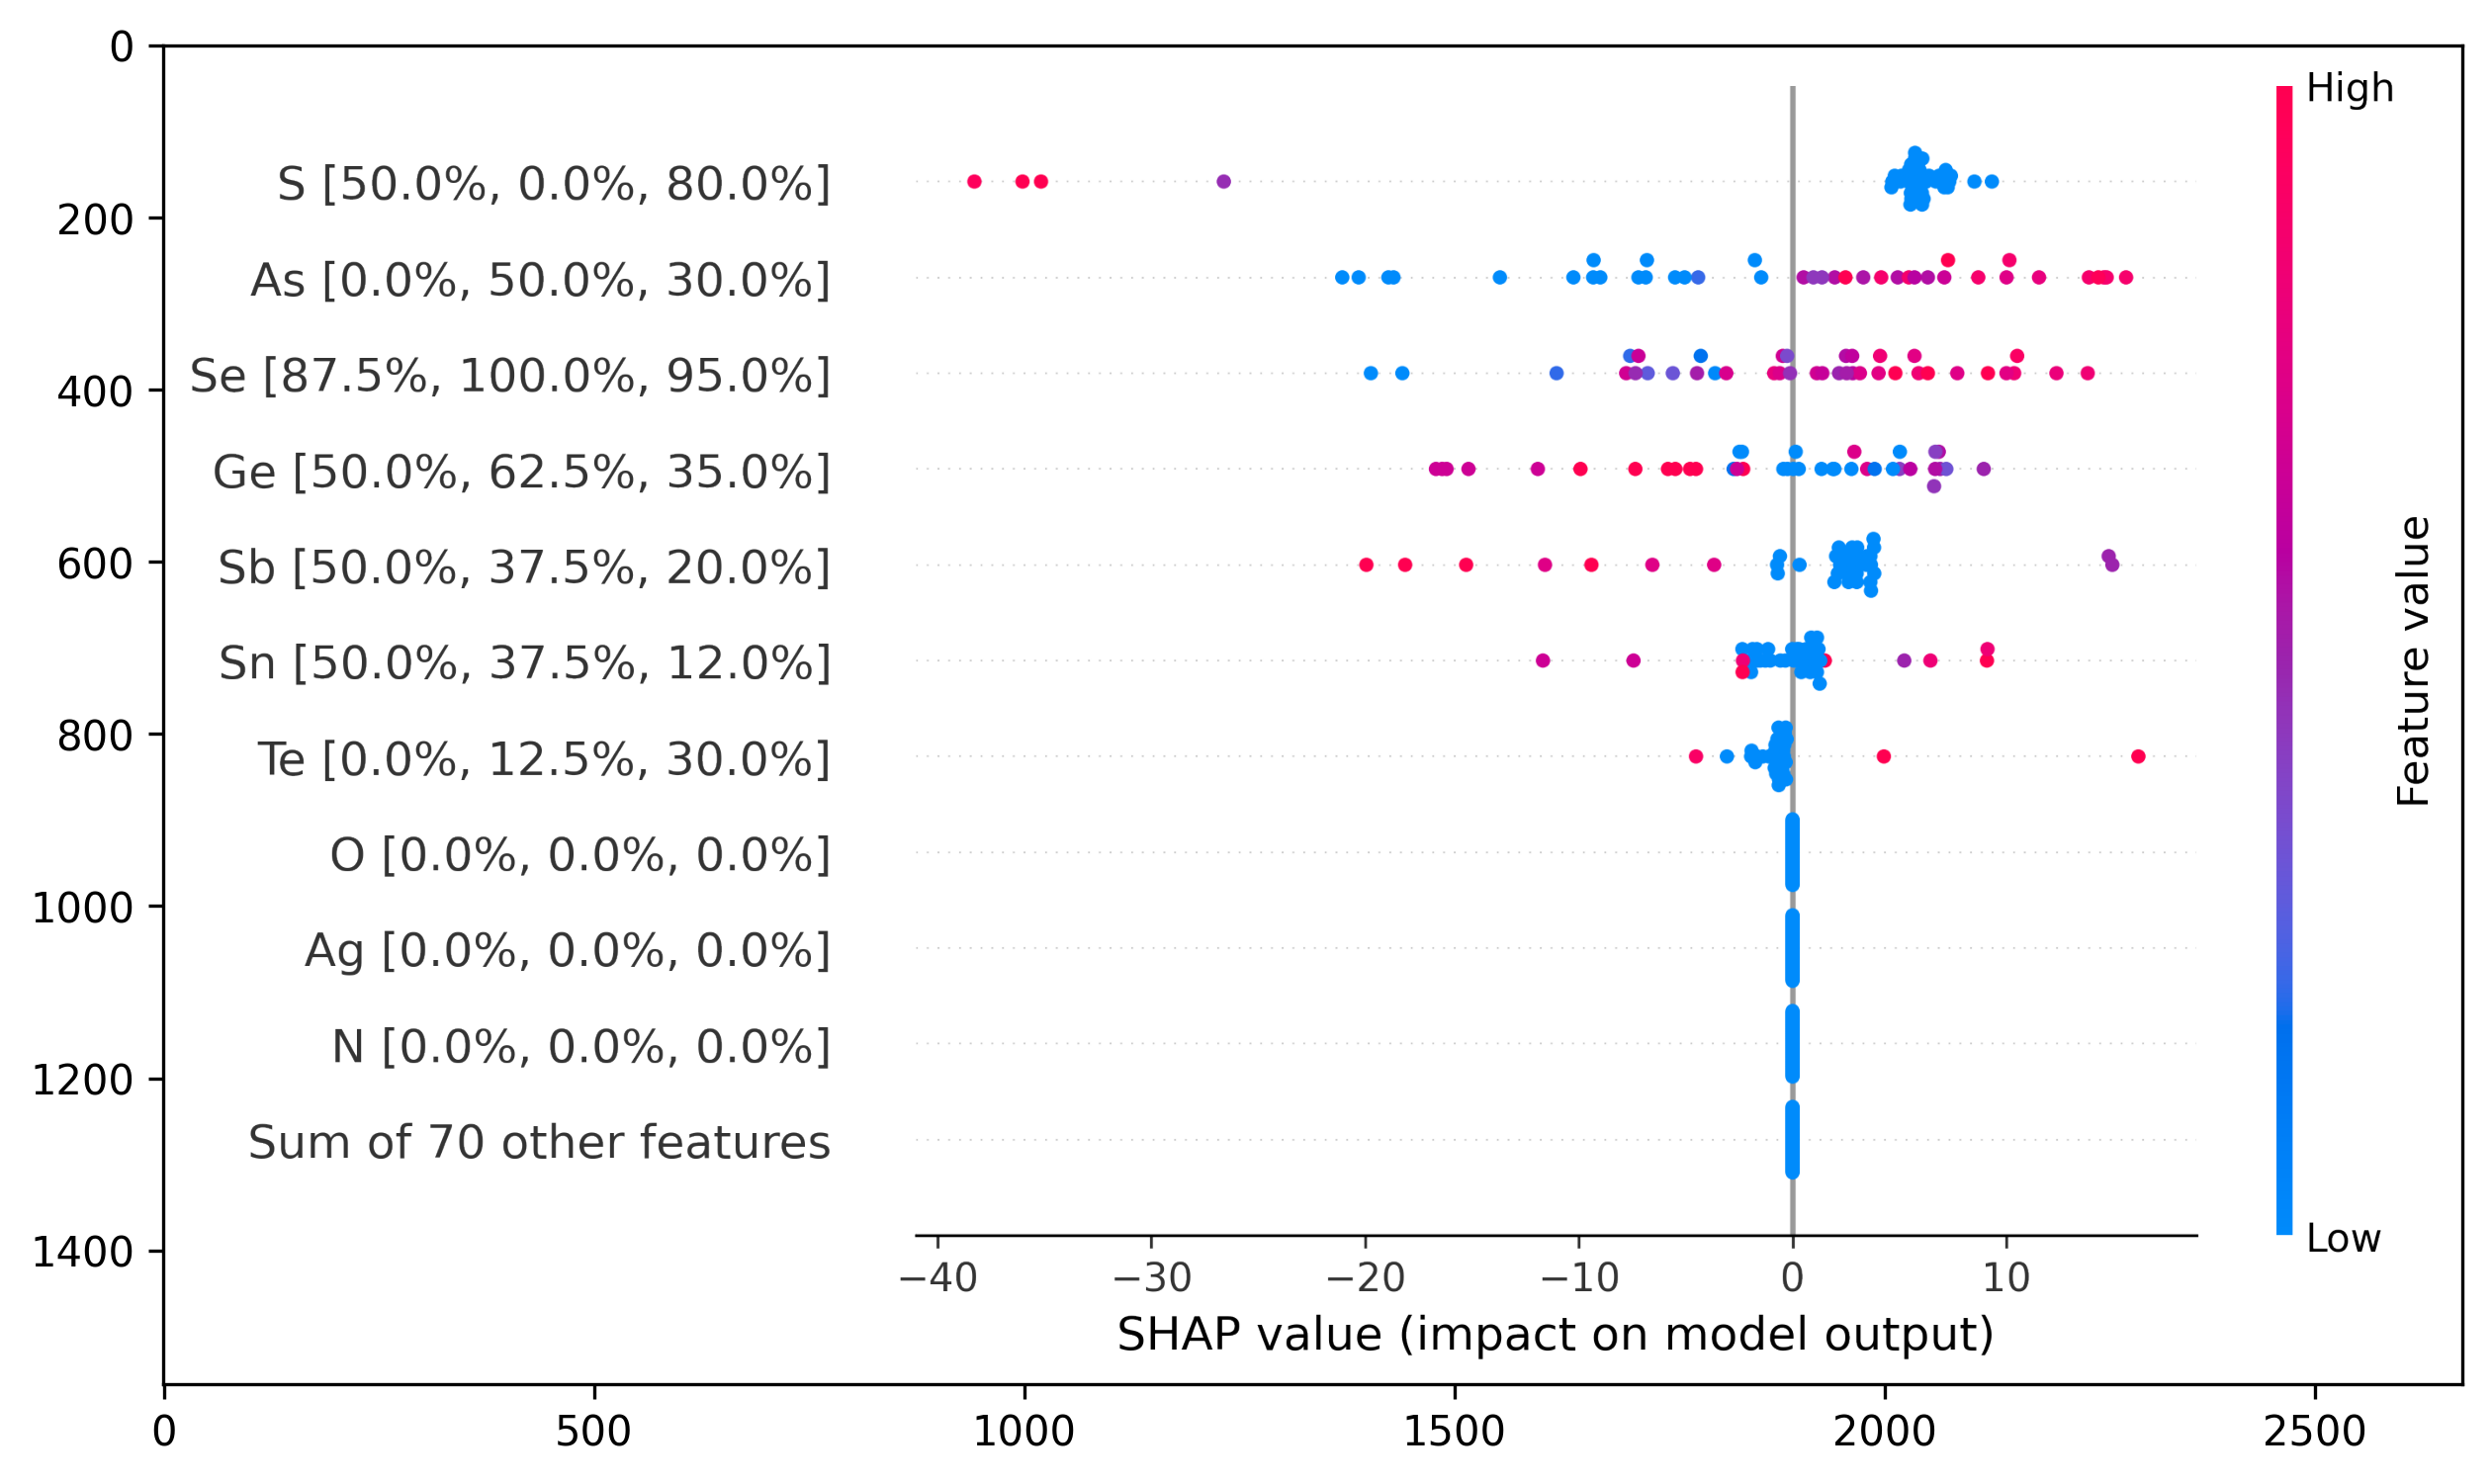

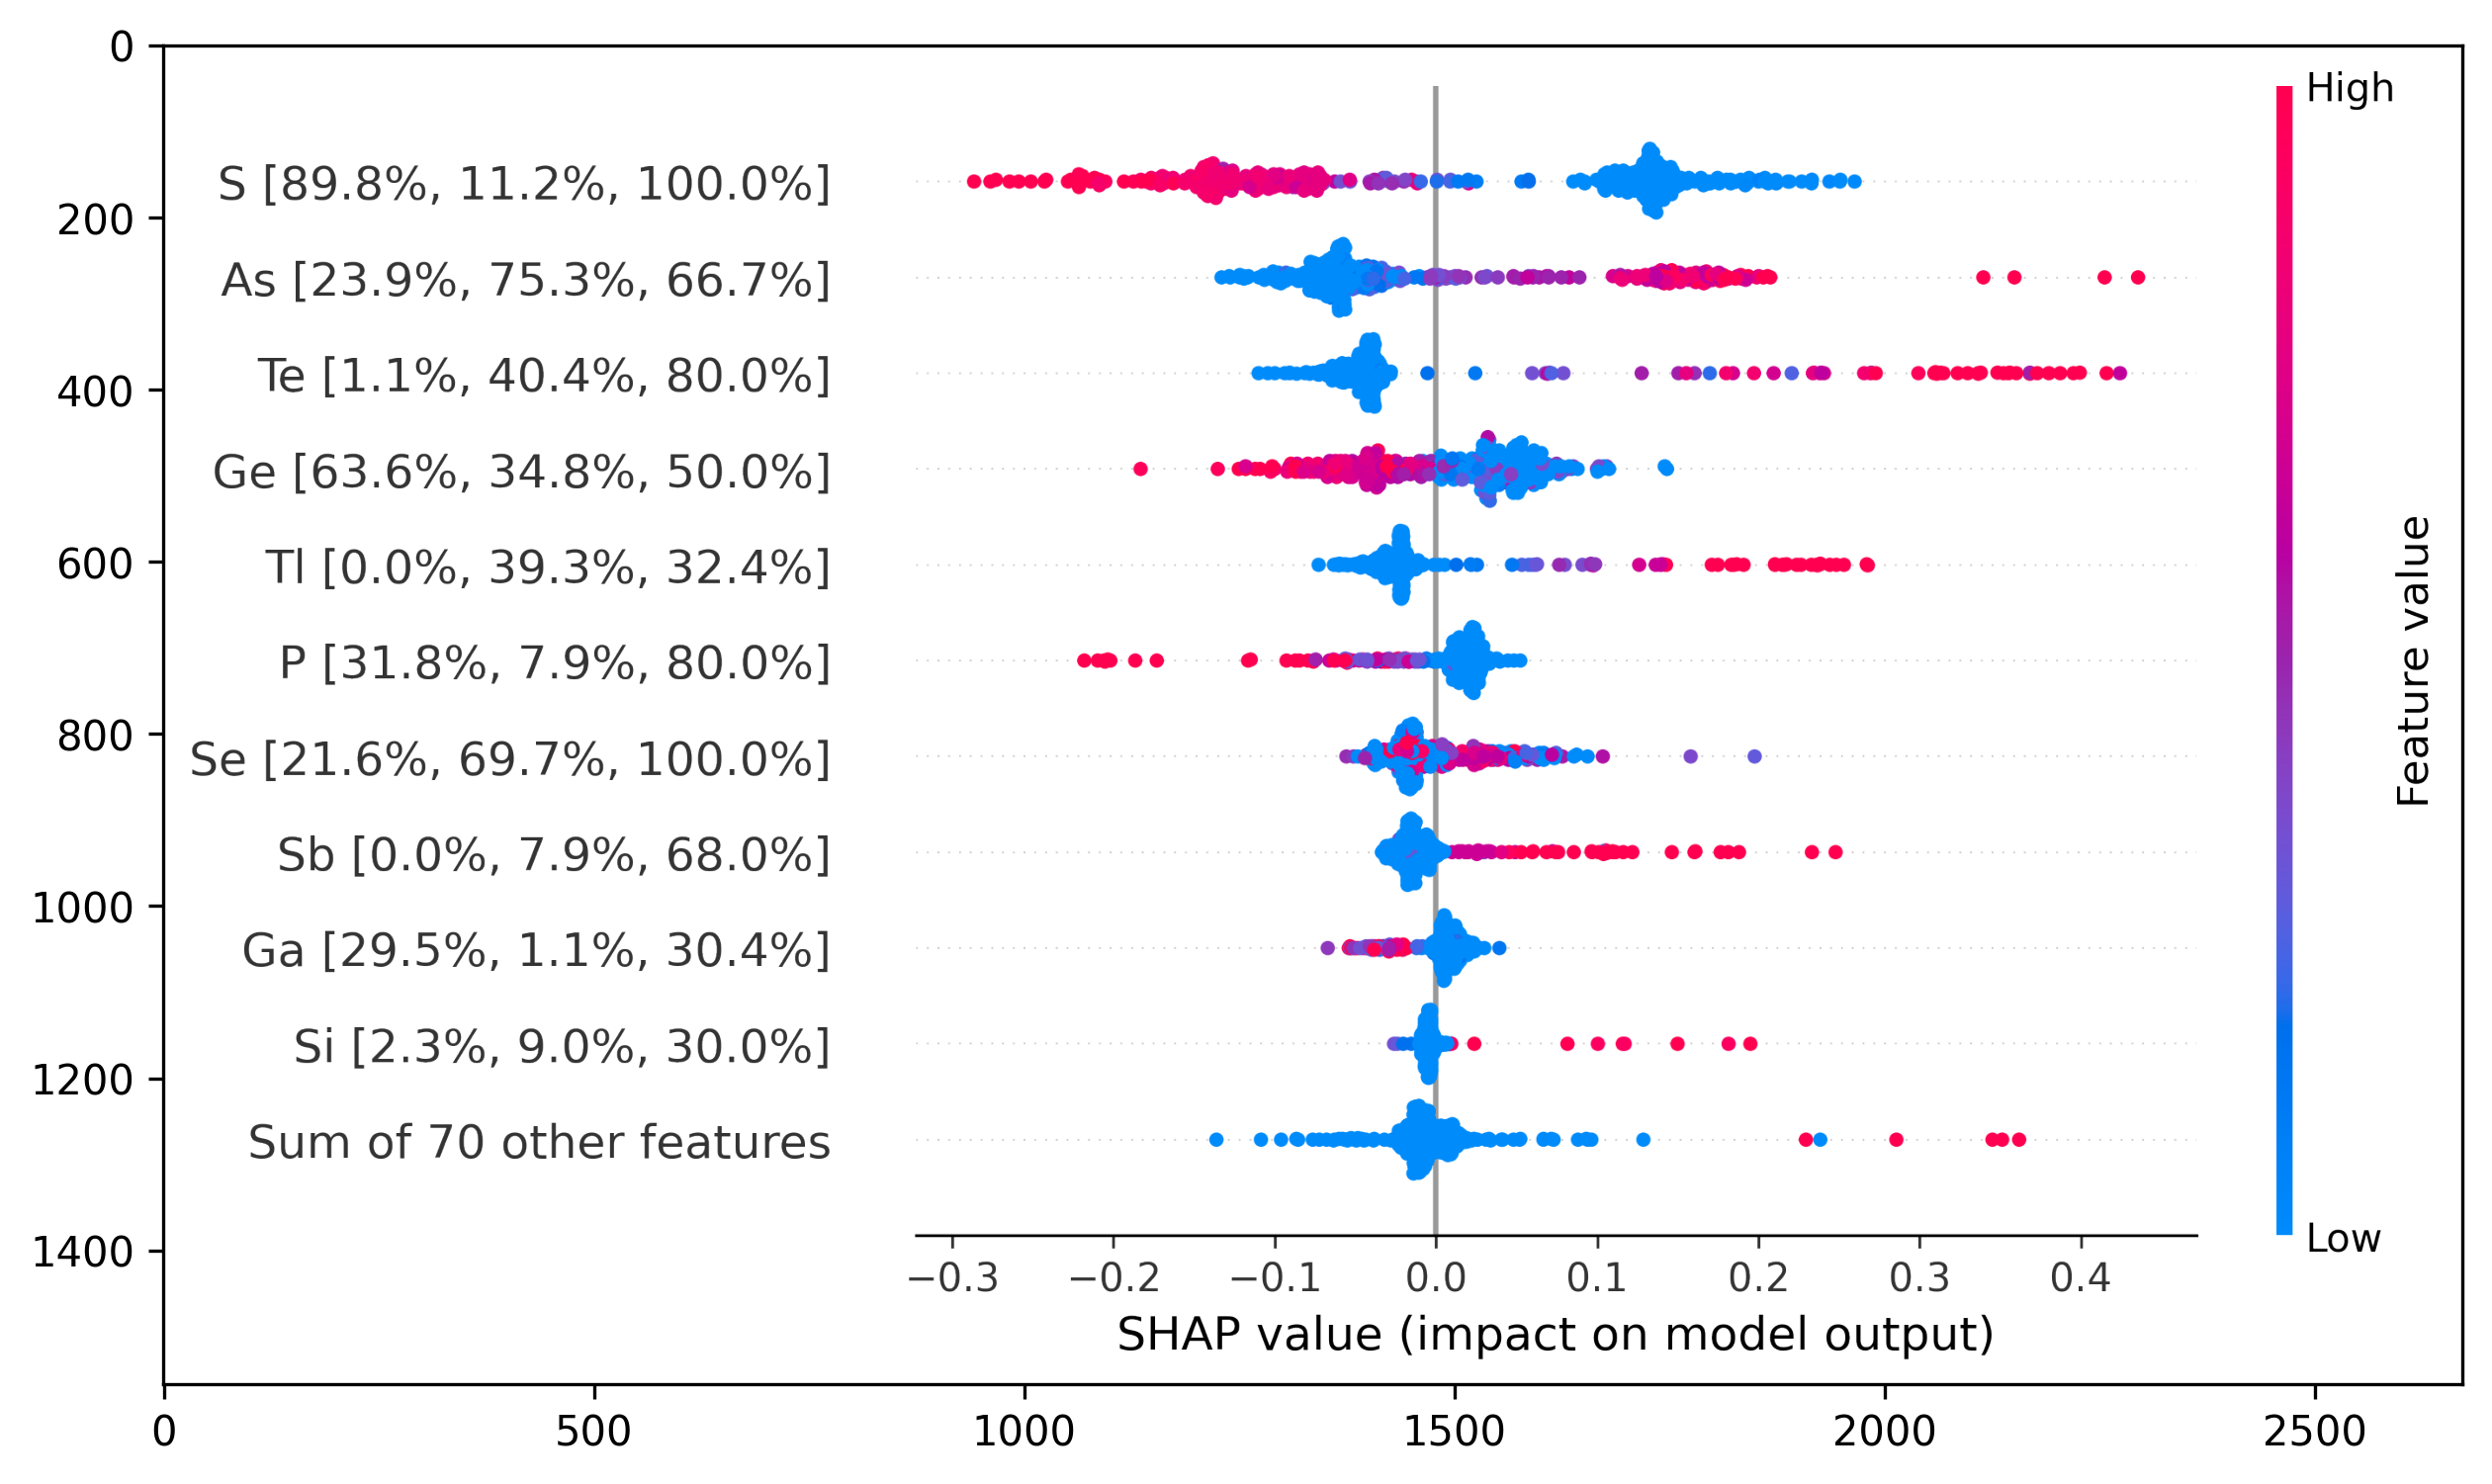

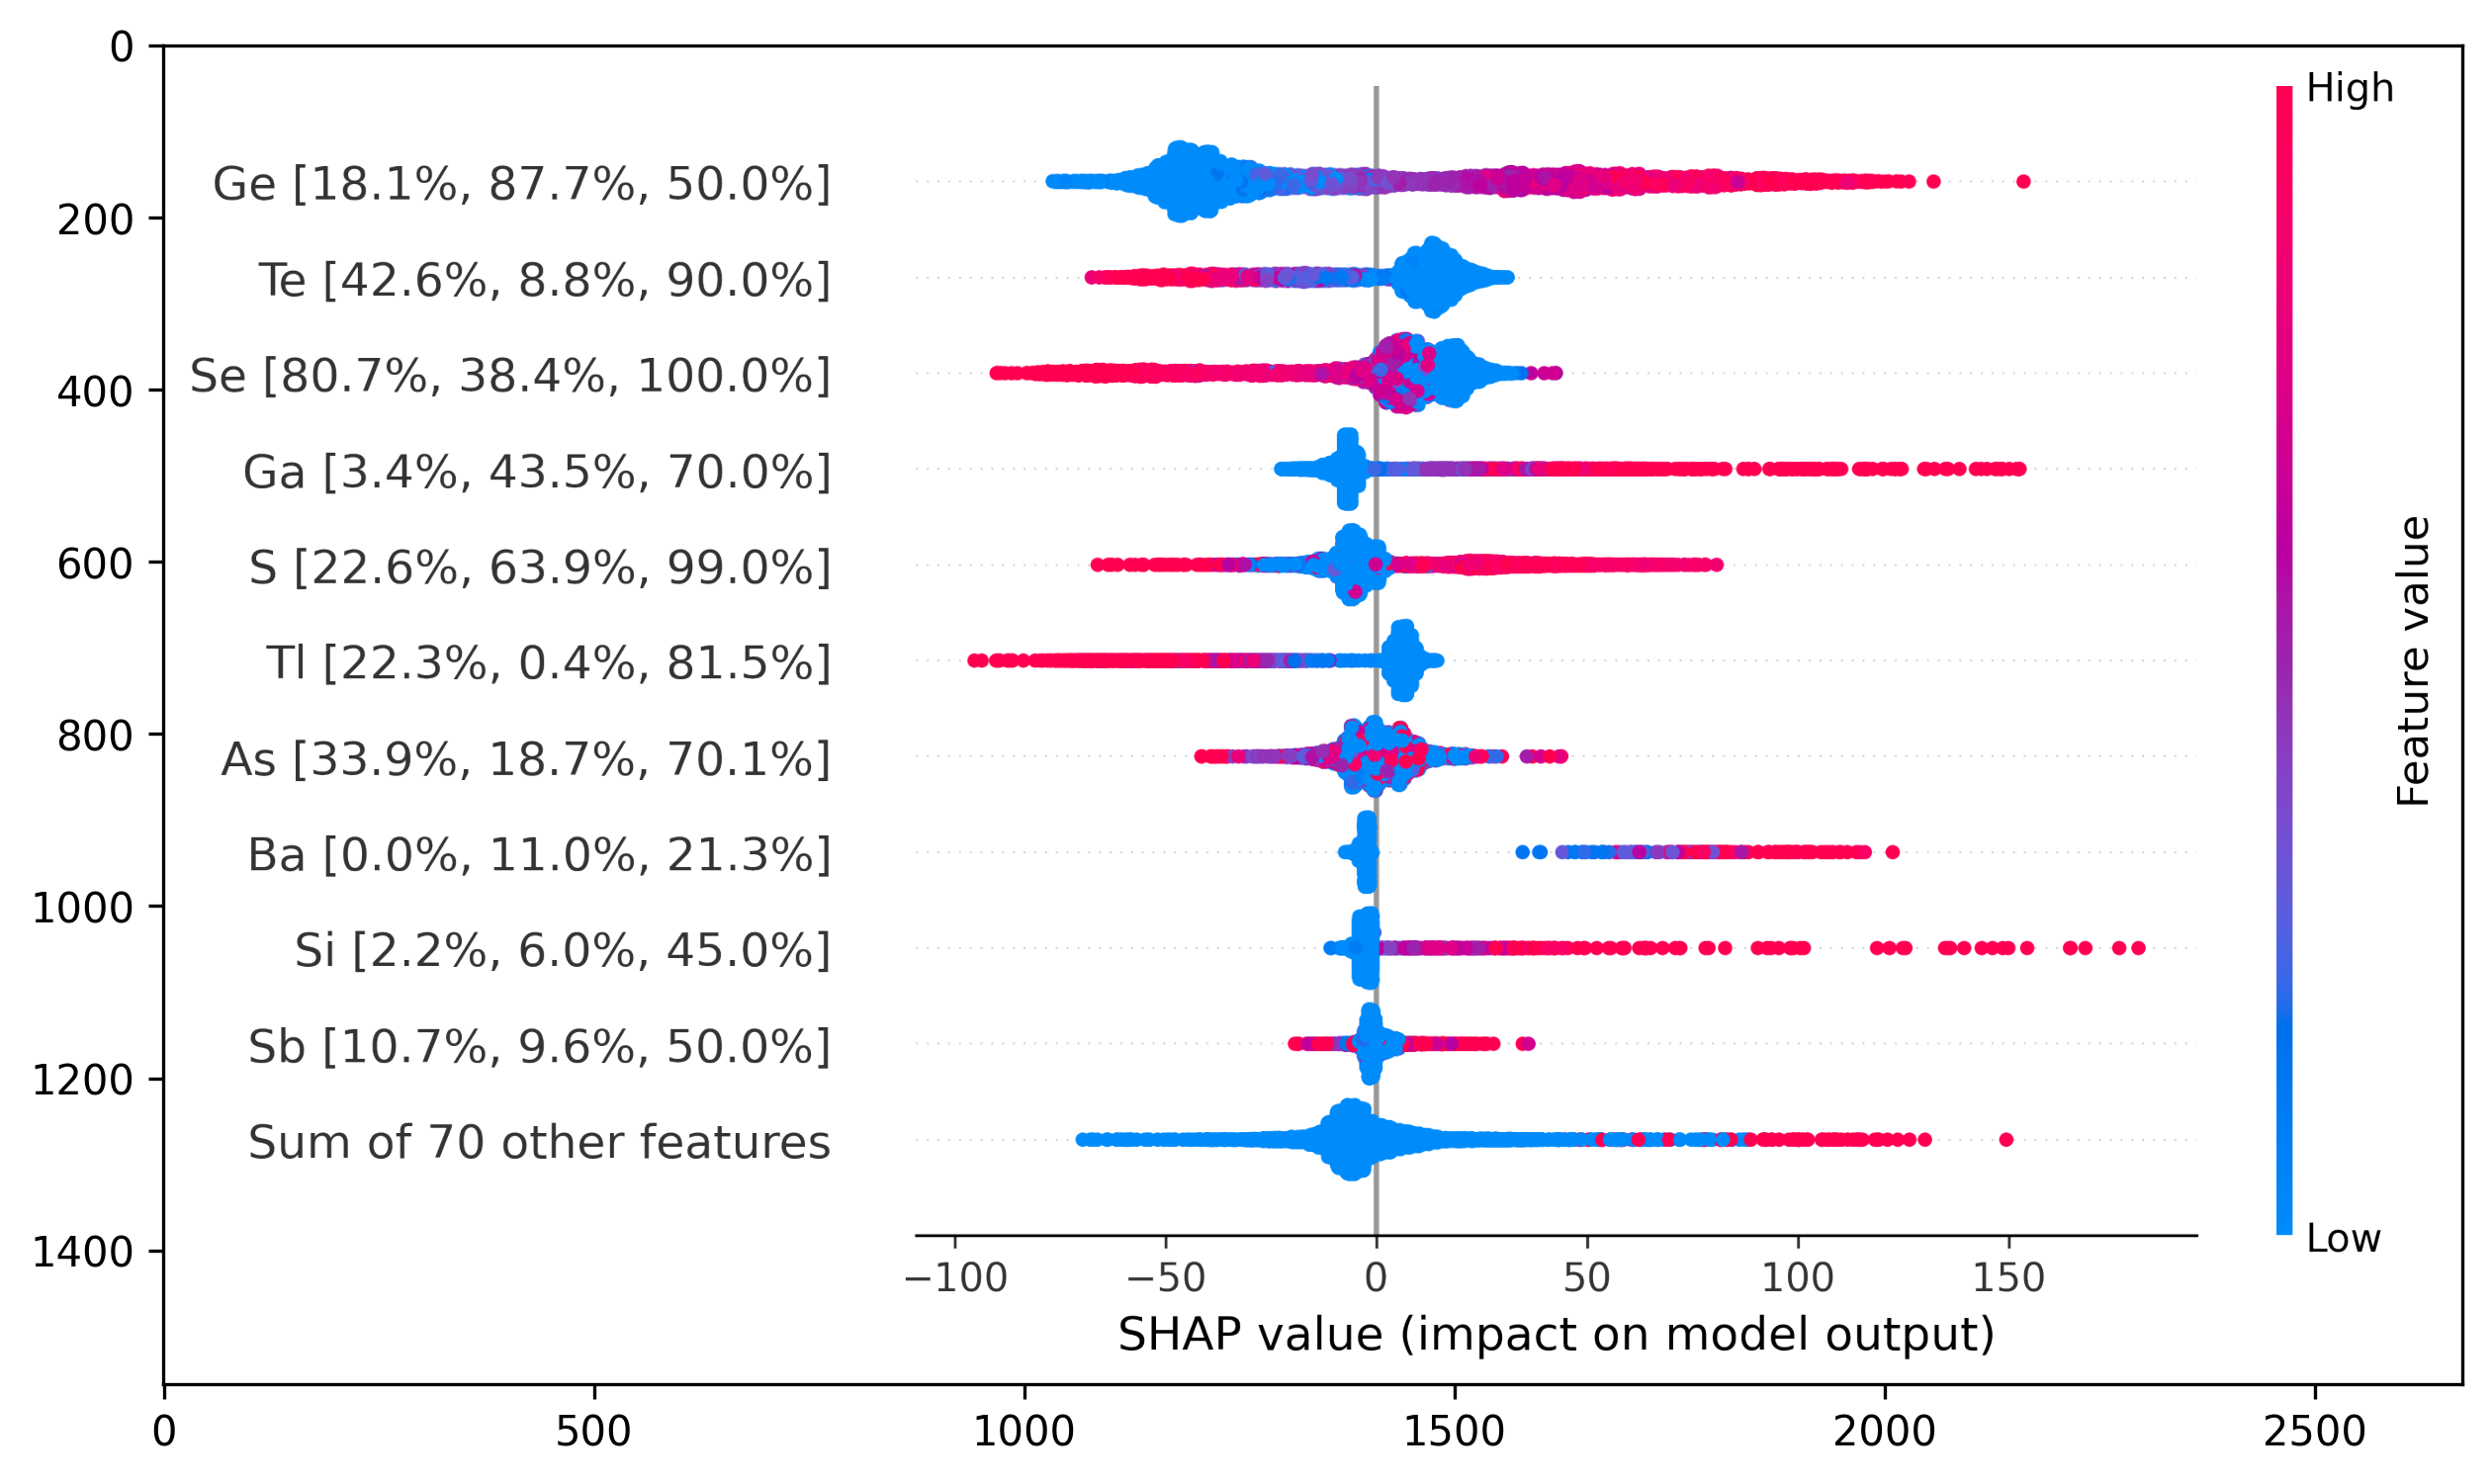

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

for mode_type in mode_types:
    for prop in props:
        fold = df_folds[prop][mode_type]
        file_name = f"{mode_type}-fold_{prop}_fold{fold}_shap"
        figure_file = f"images/{file_name}.png"
        
        figure(figsize=(10, 10), dpi=300)
        img = mpimg.imread(figure_file)
        imgplot = plt.imshow(img)
        plt.show()